# 📊 RAGiCamp Comprehensive Results Analysis

This notebook provides in-depth analysis of RAG experiment results, including:

1. **Data Loading & Overview** - Load results, understand experiment coverage
2. **Model Leaderboard** - Rank models across all metrics
3. **Prompt Impact Analysis** - Do different prompts affect performance?
4. **RAG vs Direct LLM** - When does retrieval help or hurt?
5. **Metric Correlation** - Do metrics agree on what's a good answer?
6. **Head-to-Head Competition** - Models competing on the same questions
7. **Retrieval Quality Analysis** - Link between retrieval scores and answer quality
8. **Error Pattern Analysis** - When and why do models fail?
9. **Example Browser** - Interactive exploration of predictions

In [35]:
# =============================================================================
# SETUP
# =============================================================================
import sys
import json
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Any, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# Handle notebook location
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(repo_root / 'src'))

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Analysis imports
from ragicamp.analysis import (
    ResultsLoader,
    compare_results,
    best_by,
    pivot_results,
    summarize_results,
)

# Configure plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palettes
COLORS = {
    'primary': '#2563eb',
    'secondary': '#7c3aed',
    'success': '#059669',
    'warning': '#d97706',
    'danger': '#dc2626',
}
MODEL_PALETTE = sns.color_palette('husl', 12)
METRIC_PALETTE = sns.color_palette('Set2')

print('✅ Setup complete!')

✅ Setup complete!


## 1️⃣ Data Loading & Overview

In [36]:
# =============================================================================
# CONFIGURATION - Set your results directory here
# =============================================================================
RESULTS_DIR = repo_root / 'outputs' / 'comprehensive_baseline'

# Load experiment results
loader = ResultsLoader(RESULTS_DIR)
results = loader.load_all()

print(f'📦 Loaded {len(results)} experiments from {RESULTS_DIR}')
print()

# Summary
summary = summarize_results(results)

print('=' * 70)
print('📊 EXPERIMENT OVERVIEW')
print('=' * 70)
print(f"Total experiments: {summary['count']}")
print(f"\nModels ({len(summary['models'])}): {', '.join(sorted(summary['models']))}")
print(f"\nDatasets ({len(summary['datasets'])}): {', '.join(sorted(summary['datasets']))}")
print(f"\nPrompts ({len(summary['prompts'])}): {', '.join(sorted(summary['prompts']))}")
print(f"\nTypes: {', '.join(sorted(summary['types']))}")

if 'embedding_models' in summary:
    print(f"\nEmbedding Models: {', '.join(sorted(summary['embedding_models']))}")
if 'chunk_sizes' in summary:
    print(f"Chunk Sizes: {sorted(summary['chunk_sizes'])}")

print(f"\n⏱️ Total Duration: {summary['total_duration_hours']:.1f} hours")

15:19:19 | INFO     | ragicamp.analysis.loader | Loaded 306 experiments from comparison.json
📦 Loaded 306 experiments from /home/gabriel_frontera_cloudwalk_io/ragicamp/outputs/comprehensive_baseline

📊 EXPERIMENT OVERVIEW
Total experiments: 306

Models (12): Llama-3.1-8B-Instruct, Llama-3.2-3B-Instruct, Mistral-7B-Instruct-v0.2, Mistral-7B-Instruct-v0.3, Mixtral-8x7B-Instruct-v0.1, Qwen2.5-1.5B-Instruct, Qwen2.5-32B-Instruct, Qwen2.5-7B-Instruct, deepseek-llm-7b-chat, falcon-7b-instruct, gemma-2-9b-it, gemma-2b-it

Datasets (3): hotpotqa, nq, triviaqa

Prompts (2): concise, fewshot

Types: direct, rag

Embedding Models: e5, minilm, mpnet
Chunk Sizes: [512, 1024]

⏱️ Total Duration: 12.6 hours


In [37]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame([r.to_dict() for r in results])

# Add useful columns
df['model_family'] = df['model_short'].apply(lambda x: x.split('-')[0] if '-' in x else x[:10])
df['has_rag'] = df['type'] == 'rag'

# Available metrics - prioritize LLM Judge
METRICS = ['llm_judge', 'f1', 'exact_match', 'bertscore_f1', 'bleurt']
PRIMARY_METRIC = 'llm_judge'  # Main metric for analysis

print(f'📋 DataFrame shape: {df.shape}')

📋 DataFrame shape: (306, 27)


## 📊 Experiment Coverage Summary

Understanding sample sizes is critical for interpreting results. Low sample counts mean high uncertainty.

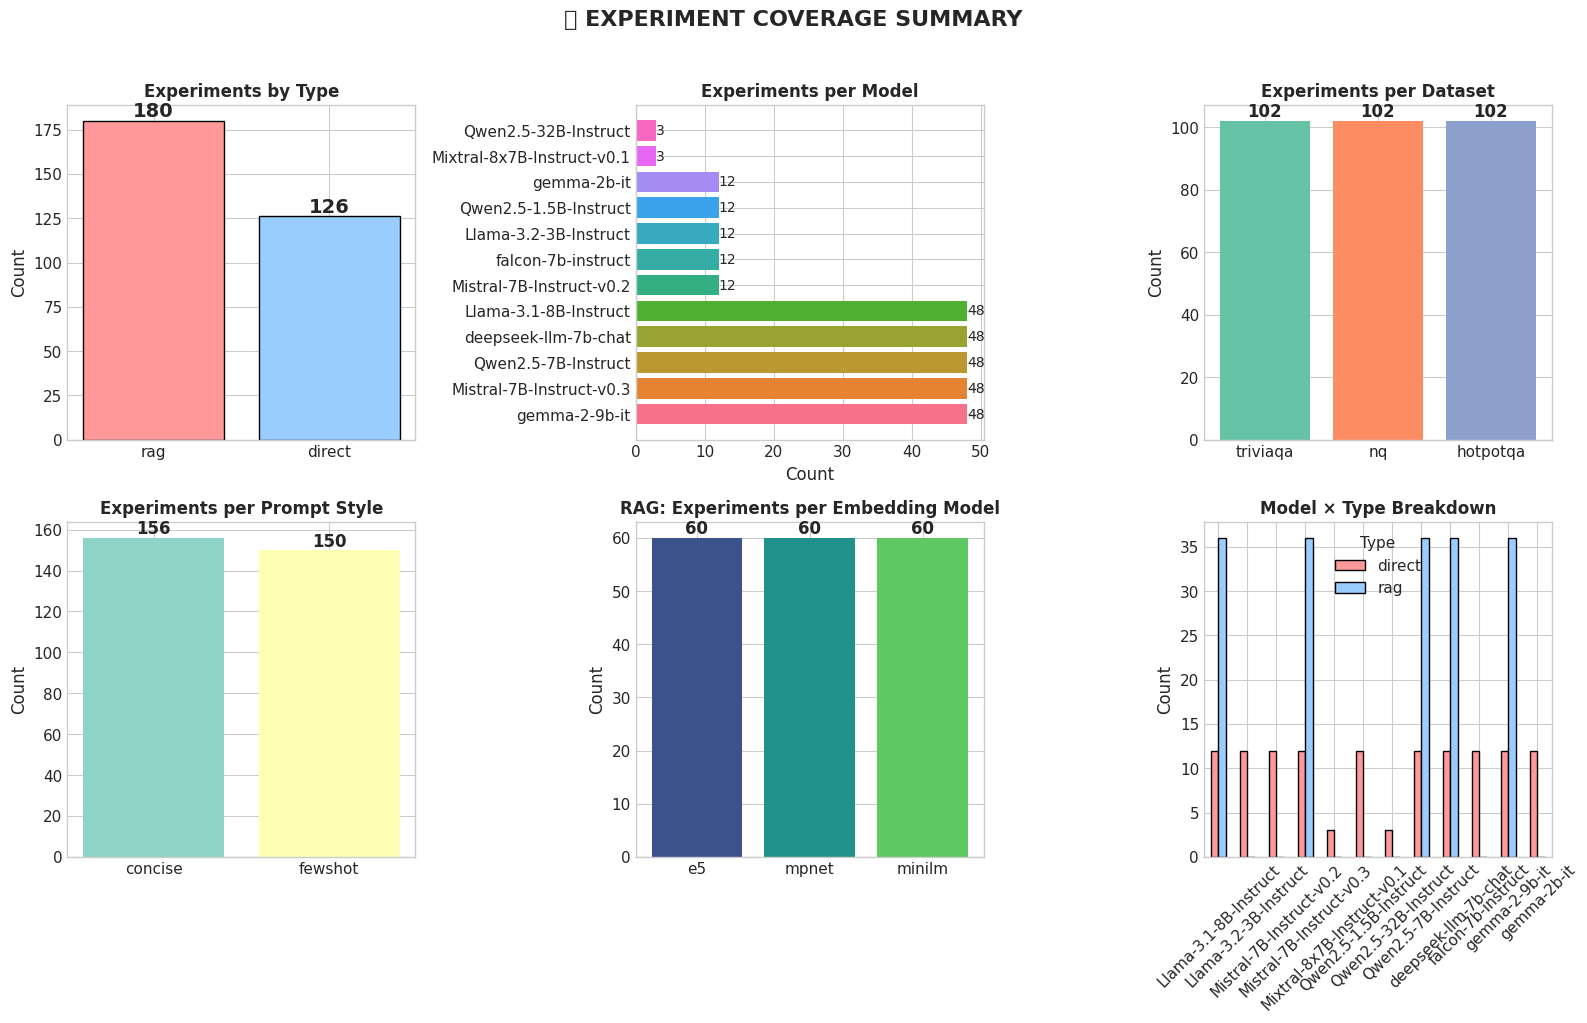


📋 COVERAGE SUMMARY
  Total Experiments             :    306
  Direct LLM                    :    126
  RAG                           :    180
  Unique Models                 :     12
  Unique Datasets               :      3
  Unique Prompts                :      2
  RAG: Embedding Models         :      3
  RAG: Chunk Sizes              :      2
  RAG: top_k Values             :      1


In [38]:
# =============================================================================
# EXPERIMENT COVERAGE - Critical for interpreting results
# =============================================================================

# Split data
df_direct = df[df['type'] == 'direct'].copy()
df_rag = df[df['type'] == 'rag'].copy()

# Build coverage summary
coverage = {
    'Total Experiments': len(df),
    'Direct LLM': len(df_direct),
    'RAG': len(df_rag),
    'Unique Models': df['model_short'].nunique(),
    'Unique Datasets': df['dataset'].nunique(),
    'Unique Prompts': df['prompt'].nunique(),
}

# RAG-specific coverage
if len(df_rag) > 0:
    coverage['RAG: Embedding Models'] = df_rag['embedding_model'].nunique()
    coverage['RAG: Chunk Sizes'] = df_rag['chunk_size'].nunique()
    coverage['RAG: top_k Values'] = df_rag['top_k'].nunique()

# Create visual summary
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Type distribution (Direct vs RAG)
ax = axes[0, 0]
type_counts = df['type'].value_counts()
colors = ['#ff9999', '#99ccff']
bars = ax.bar(type_counts.index, type_counts.values, color=colors, edgecolor='black')
ax.set_title('Experiments by Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Count')
for bar in bars:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
               ha='center', va='bottom', fontsize=14, fontweight='bold')

# 2. Models distribution
ax = axes[0, 1]
model_counts = df['model_short'].value_counts()
bars = ax.barh(model_counts.index, model_counts.values, color=sns.color_palette('husl', len(model_counts)))
ax.set_title('Experiments per Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Count')
for bar in bars:
    ax.annotate(f'{int(bar.get_width())}', xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
               ha='left', va='center', fontsize=10)

# 3. Dataset distribution
ax = axes[0, 2]
dataset_counts = df['dataset'].value_counts()
bars = ax.bar(dataset_counts.index, dataset_counts.values, color=sns.color_palette('Set2', len(dataset_counts)))
ax.set_title('Experiments per Dataset', fontsize=12, fontweight='bold')
ax.set_ylabel('Count')
for bar in bars:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
               ha='center', va='bottom', fontsize=12, fontweight='bold')

# 4. Prompt distribution
ax = axes[1, 0]
prompt_counts = df['prompt'].value_counts()
bars = ax.bar(prompt_counts.index, prompt_counts.values, color=sns.color_palette('Set3', len(prompt_counts)))
ax.set_title('Experiments per Prompt Style', fontsize=12, fontweight='bold')
ax.set_ylabel('Count')
for bar in bars:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
               ha='center', va='bottom', fontsize=12, fontweight='bold')

# 5. RAG Embedding Models (if available)
ax = axes[1, 1]
if len(df_rag) > 0:
    emb_counts = df_rag['embedding_model'].value_counts()
    bars = ax.bar(emb_counts.index, emb_counts.values, color=sns.color_palette('viridis', len(emb_counts)))
    ax.set_title('RAG: Experiments per Embedding Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count')
    for bar in bars:
        ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   ha='center', va='bottom', fontsize=12, fontweight='bold')
else:
    ax.text(0.5, 0.5, 'No RAG experiments', ha='center', va='center', fontsize=14)
    ax.set_axis_off()

# 6. Model × Type breakdown
ax = axes[1, 2]
model_type = df.groupby(['model_short', 'type']).size().unstack(fill_value=0)
model_type.plot(kind='bar', ax=ax, color=['#ff9999', '#99ccff'], edgecolor='black')
ax.set_title('Model × Type Breakdown', fontsize=12, fontweight='bold')
ax.set_ylabel('Count')
ax.set_xlabel('')
ax.legend(title='Type')
ax.tick_params(axis='x', rotation=45)

plt.suptitle('📊 EXPERIMENT COVERAGE SUMMARY', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary table
print('\n' + '=' * 60)
print('📋 COVERAGE SUMMARY')
print('=' * 60)
for k, v in coverage.items():
    print(f'  {k:<30}: {v:>6}')
print('=' * 60)

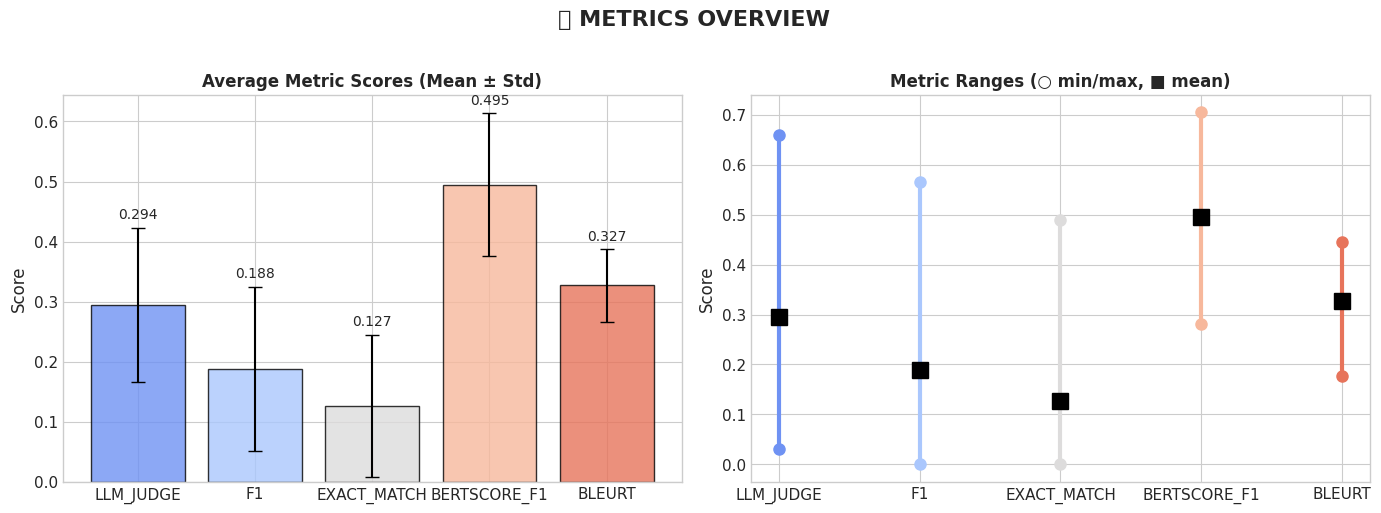

,metric,count,mean,std,min,max
0,LLM_JUDGE,298,0.2945,0.1284,0.0300,0.6600
1,F1,306,0.1881,0.1369,0.0014,0.5650
2,EXACT_MATCH,306,0.1269,0.1185,0.0000,0.4900
3,BERTSCORE_F1,306,0.4946,0.1190,0.2803,0.7049
4,BLEURT,306,0.3271,0.0602,0.1770,0.4463


In [39]:
# =============================================================================
# METRICS OVERVIEW - Visual summary of all metrics
# =============================================================================

# Build metrics summary
metrics_summary = []
for metric in METRICS:
    if metric in df.columns:
        valid = df[metric].dropna()
        if len(valid) > 0:
            metrics_summary.append({
                'metric': metric.upper(),
                'count': len(valid),
                'mean': valid.mean(),
                'std': valid.std(),
                'min': valid.min(),
                'max': valid.max(),
            })

metrics_df = pd.DataFrame(metrics_summary)

# Create visual summary
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Mean ± Std for each metric
ax = axes[0]
x = np.arange(len(metrics_df))
bars = ax.bar(x, metrics_df['mean'], yerr=metrics_df['std'], capsize=5, 
              color=sns.color_palette('coolwarm', len(metrics_df)), edgecolor='black', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['metric'])
ax.set_ylabel('Score')
ax.set_title('Average Metric Scores (Mean ± Std)', fontsize=12, fontweight='bold')
for i, (bar, row) in enumerate(zip(bars, metrics_df.itertuples())):
    ax.annotate(f'{row.mean:.3f}', xy=(bar.get_x() + bar.get_width()/2, row.mean + row.std + 0.01),
               ha='center', va='bottom', fontsize=10)

# 2. Min-Max range for each metric
ax = axes[1]
for i, row in metrics_df.iterrows():
    ax.plot([i, i], [row['min'], row['max']], 'o-', markersize=8, linewidth=3, 
            color=sns.color_palette('coolwarm', len(metrics_df))[i])
    ax.plot(i, row['mean'], 's', markersize=12, color='black', zorder=5)
ax.set_xticks(range(len(metrics_df)))
ax.set_xticklabels(metrics_df['metric'])
ax.set_ylabel('Score')
ax.set_title('Metric Ranges (○ min/max, ■ mean)', fontsize=12, fontweight='bold')

plt.suptitle('📈 METRICS OVERVIEW', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Display as styled table
display(metrics_df.style.format({
    'mean': '{:.4f}', 'std': '{:.4f}', 'min': '{:.4f}', 'max': '{:.4f}'
}).background_gradient(subset=['mean'], cmap='RdYlGn'))

## 🎯 Performance Drivers Analysis

What factors have the **biggest impact** on performance? This analysis helps prioritize optimization efforts.

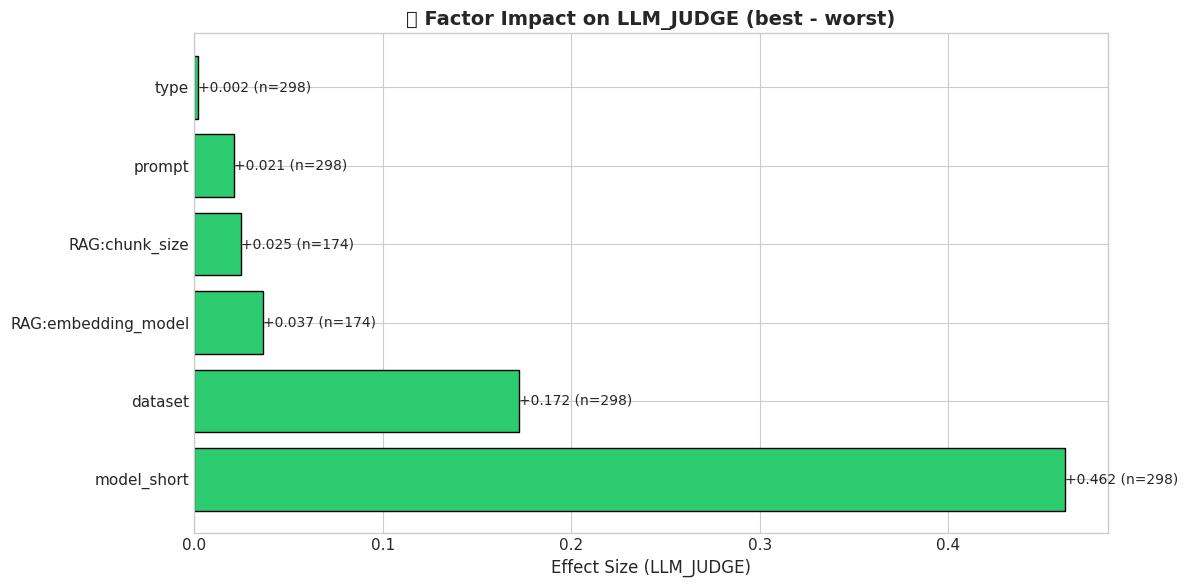

📊 Effect sizes with sample counts:


,factor,best,worst,best_score,worst_score,effect_size,n_groups,total_n
0,model_short,Mixtral-8x7B-Instruct-v0.1,gemma-2b-it,0.5367,0.0750,0.4617,12,298
2,dataset,triviaqa,hotpotqa,0.3722,0.1998,0.1724,3,298
4,RAG:embedding_model,e5,minilm,0.3136,0.2771,0.0366,3,174
5,RAG:chunk_size,512,1024,0.3019,0.2771,0.0248,2,174
3,prompt,fewshot,concise,0.3056,0.2844,0.0211,2,298
1,type,direct,rag,0.2957,0.2936,0.0021,2,298


In [40]:
# =============================================================================
# PERFORMANCE DRIVERS - What factors matter most?
# =============================================================================

def compute_effect_size(data, group_col, metric):
    """Compute effect size with sample counts."""
    if metric not in data.columns:
        return None
    grouped = data.groupby(group_col)[metric].agg(['mean', 'std', 'count']).dropna()
    if len(grouped) < 2:
        return None
    best_g, worst_g = grouped['mean'].idxmax(), grouped['mean'].idxmin()
    effect = grouped.loc[best_g, 'mean'] - grouped.loc[worst_g, 'mean']
    return {
        'factor': group_col, 'best': best_g, 'worst': worst_g,
        'best_score': grouped.loc[best_g, 'mean'], 'worst_score': grouped.loc[worst_g, 'mean'],
        'effect_size': effect, 'n_groups': len(grouped), 'total_n': grouped['count'].sum(),
    }

# Compute effects for all factors
factors = ['model_short', 'type', 'dataset', 'prompt']
effects = [compute_effect_size(df, f, PRIMARY_METRIC) for f in factors]
for f in ['embedding_model', 'chunk_size', 'top_k']:
    e = compute_effect_size(df_rag, f, PRIMARY_METRIC)
    if e:
        e['factor'] = f'RAG:{f}'
        effects.append(e)
effects = [e for e in effects if e]
effects_df = pd.DataFrame(effects).sort_values('effect_size', ascending=False)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in effects_df['effect_size']]
bars = ax.barh(effects_df['factor'], effects_df['effect_size'], color=colors, edgecolor='black')
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel(f'Effect Size ({PRIMARY_METRIC.upper()})')
ax.set_title(f'🎯 Factor Impact on {PRIMARY_METRIC.upper()} (best - worst)', fontsize=14, fontweight='bold')
for i, (_, row) in enumerate(effects_df.iterrows()):
    ax.annotate(f"+{row['effect_size']:.3f} (n={int(row['total_n'])})", 
               xy=(max(row['effect_size'], 0.001), i), ha='left', va='center', fontsize=10)
plt.tight_layout()
plt.show()

print('📊 Effect sizes with sample counts:')
display(effects_df.style.format({'best_score': '{:.4f}', 'worst_score': '{:.4f}', 'effect_size': '{:.4f}'}))

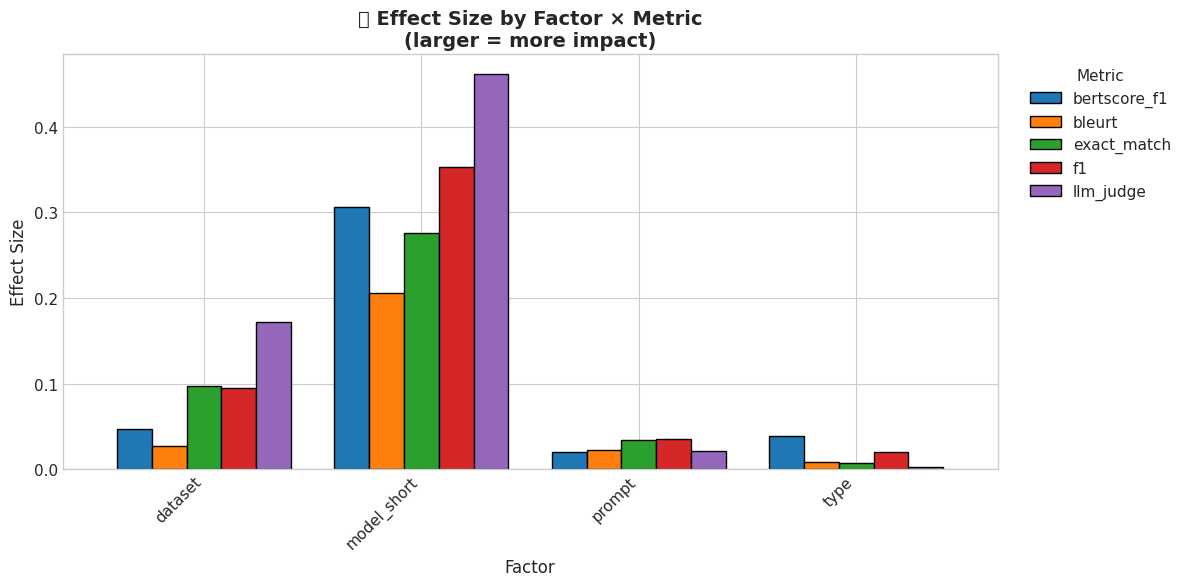

\n📊 Effect Size Matrix (Factor × Metric):


metric,bertscore_f1,bleurt,exact_match,f1,llm_judge
factor,,,,,
dataset,0.0473,0.0274,0.0972,0.0944,0.1724
model_short,0.3066,0.2062,0.2762,0.3531,0.4617
prompt,0.0197,0.0221,0.0339,0.0357,0.0211
type,0.0388,0.0084,0.0067,0.0202,0.0021


In [41]:
# =============================================================================
# MULTI-METRIC COMPARISON - Same analysis across all metrics
# =============================================================================

# Compare effect sizes across metrics
all_effects = []
for metric in METRICS:
    if metric not in df.columns:
        continue
    for factor in ['model_short', 'type', 'dataset', 'prompt']:
        e = compute_effect_size(df, factor, metric)
        if e:
            e['metric'] = metric
            all_effects.append(e)

all_effects_df = pd.DataFrame(all_effects)

# Pivot: factor × metric
if len(all_effects_df) > 0:
    pivot = all_effects_df.pivot(index='factor', columns='metric', values='effect_size').fillna(0)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
    ax.set_ylabel('Effect Size')
    ax.set_xlabel('Factor')
    ax.set_title('🔬 Effect Size by Factor × Metric\n(larger = more impact)', fontsize=14, fontweight='bold')
    ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.axhline(0, color='black', linewidth=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print('\\n📊 Effect Size Matrix (Factor × Metric):')
    display(pivot.style.format('{:.4f}').background_gradient(cmap='RdYlGn', axis=None))

🎯 PERFORMANCE DRIVERS FOR LLM_JUDGE


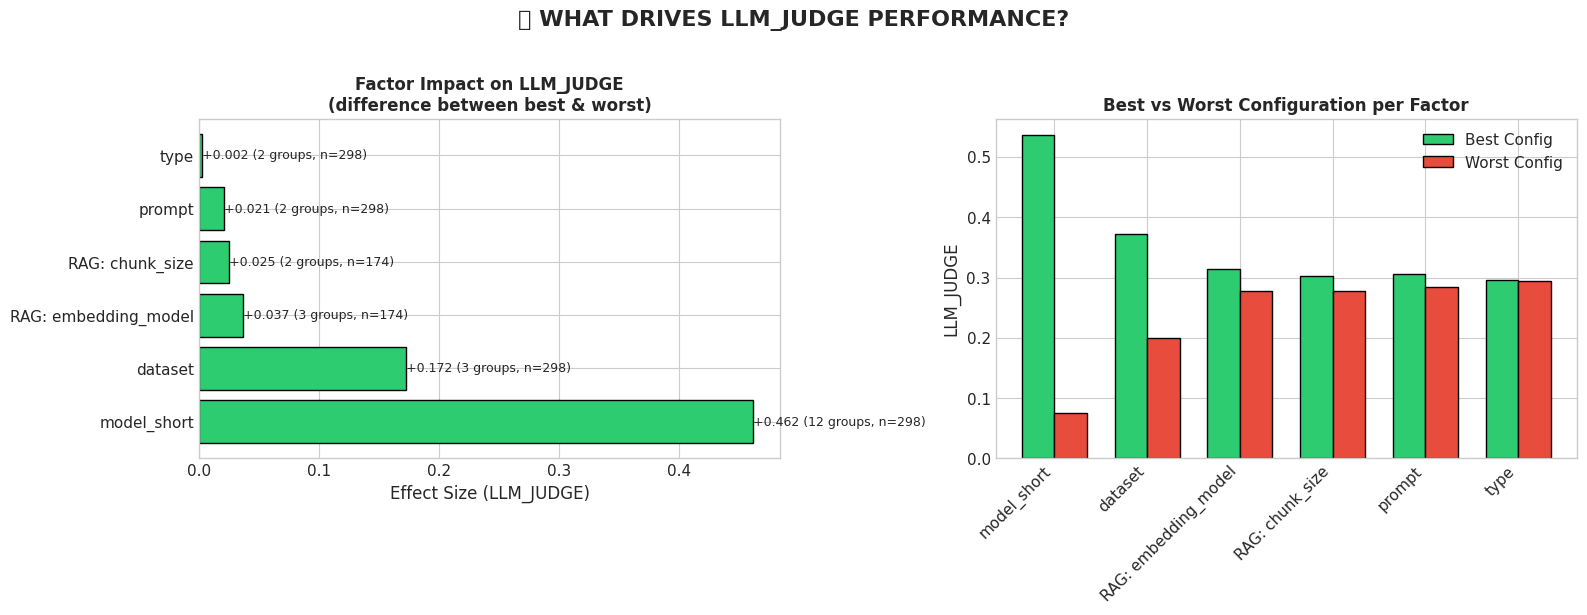


Detailed Effect Analysis:


,factor,best,worst,best_score,worst_score,effect_size,effect_pct,total_n
0,model_short,Mixtral-8x7B-Instruct-v0.1,gemma-2b-it,0.5367,0.0750,0.4617,+615.6%,298
2,dataset,triviaqa,hotpotqa,0.3722,0.1998,0.1724,+86.3%,298
4,RAG: embedding_model,e5,minilm,0.3136,0.2771,0.0366,+13.2%,174
5,RAG: chunk_size,512,1024,0.3019,0.2771,0.0248,+9.0%,174
3,prompt,fewshot,concise,0.3056,0.2844,0.0211,+7.4%,298
1,type,direct,rag,0.2957,0.2936,0.0021,+0.7%,298


In [42]:
# =============================================================================
# PERFORMANCE DRIVERS - What factors matter most?
# =============================================================================

def compute_effect_size(df: pd.DataFrame, group_col: str, metric: str) -> dict:
    """Compute effect size (difference between best and worst group) with sample counts."""
    if metric not in df.columns:
        return None
    
    grouped = df.groupby(group_col)[metric].agg(['mean', 'std', 'count']).dropna()
    if len(grouped) < 2:
        return None
    
    best_group = grouped['mean'].idxmax()
    worst_group = grouped['mean'].idxmin()
    effect = grouped.loc[best_group, 'mean'] - grouped.loc[worst_group, 'mean']
    
    return {
        'factor': group_col,
        'best': best_group,
        'worst': worst_group,
        'best_score': grouped.loc[best_group, 'mean'],
        'worst_score': grouped.loc[worst_group, 'mean'],
        'effect_size': effect,
        'effect_pct': (effect / grouped.loc[worst_group, 'mean'] * 100) if grouped.loc[worst_group, 'mean'] > 0 else 0,
        'n_groups': len(grouped),
        'total_n': grouped['count'].sum(),
    }

# Analyze factors for each metric
factors_to_analyze = ['model_short', 'type', 'dataset', 'prompt']
rag_factors = ['embedding_model', 'chunk_size', 'top_k']

# For PRIMARY_METRIC (llm_judge)
print(f'🎯 PERFORMANCE DRIVERS FOR {PRIMARY_METRIC.upper()}')
print('=' * 80)

# All experiments
effects_all = []
for factor in factors_to_analyze:
    effect = compute_effect_size(df, factor, PRIMARY_METRIC)
    if effect:
        effects_all.append(effect)

# RAG-only factors
for factor in rag_factors:
    effect = compute_effect_size(df_rag, factor, PRIMARY_METRIC)
    if effect:
        effect['factor'] = f'RAG: {factor}'
        effects_all.append(effect)

effects_df = pd.DataFrame(effects_all).sort_values('effect_size', ascending=False)

# Visualize effect sizes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Effect size bar chart
ax = axes[0]
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in effects_df['effect_size']]
bars = ax.barh(effects_df['factor'], effects_df['effect_size'], color=colors, edgecolor='black')
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel(f'Effect Size ({PRIMARY_METRIC.upper()})')
ax.set_title(f'Factor Impact on {PRIMARY_METRIC.upper()}\n(difference between best & worst)', fontsize=12, fontweight='bold')

# Add annotations with best/worst and sample counts
for i, (_, row) in enumerate(effects_df.iterrows()):
    label = f"+{row['effect_size']:.3f} ({row['n_groups']} groups, n={int(row['total_n'])})"
    ax.annotate(label, xy=(row['effect_size'], i), 
               ha='left' if row['effect_size'] > 0 else 'right',
               va='center', fontsize=9)

# 2. Best vs Worst comparison
ax = axes[1]
x = np.arange(len(effects_df))
width = 0.35
bars1 = ax.bar(x - width/2, effects_df['best_score'], width, label='Best Config', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, effects_df['worst_score'], width, label='Worst Config', color='#e74c3c', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(effects_df['factor'], rotation=45, ha='right')
ax.set_ylabel(PRIMARY_METRIC.upper())
ax.set_title('Best vs Worst Configuration per Factor', fontsize=12, fontweight='bold')
ax.legend()

plt.suptitle(f'🎯 WHAT DRIVES {PRIMARY_METRIC.upper()} PERFORMANCE?', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Display table with details
print('\nDetailed Effect Analysis:')
display(effects_df[['factor', 'best', 'worst', 'best_score', 'worst_score', 'effect_size', 'effect_pct', 'total_n']].style.format({
    'best_score': '{:.4f}', 'worst_score': '{:.4f}', 'effect_size': '{:.4f}', 'effect_pct': '{:+.1f}%'
}).background_gradient(subset=['effect_size'], cmap='RdYlGn'))

## 2️⃣ Model Leaderboard

Rank models across all metrics to find the best performers.

In [43]:
# Create model leaderboard
def create_leaderboard(df: pd.DataFrame, metrics: List[str], group_col: str = 'model_short') -> pd.DataFrame:
    """Create a leaderboard ranking models by average across metrics."""
    agg_dict = {m: ['mean', 'std', 'count'] for m in metrics if m in df.columns}
    leaderboard = df.groupby(group_col).agg(agg_dict)
    
    # Flatten column names
    leaderboard.columns = ['_'.join(col).strip() for col in leaderboard.columns.values]
    
    # Add average rank across metrics
    ranks = []
    for metric in metrics:
        mean_col = f'{metric}_mean'
        if mean_col in leaderboard.columns:
            ranks.append(leaderboard[mean_col].rank(ascending=False))
    
    if ranks:
        leaderboard['avg_rank'] = pd.concat(ranks, axis=1).mean(axis=1)
        leaderboard = leaderboard.sort_values('avg_rank')
    
    return leaderboard

leaderboard = create_leaderboard(df, METRICS)

print('🏆 MODEL LEADERBOARD (sorted by average rank across metrics)')
print('=' * 100)

# Display key columns
display_cols = [f'{m}_mean' for m in METRICS if f'{m}_mean' in leaderboard.columns]
if 'avg_rank' in leaderboard.columns:
    display_cols.append('avg_rank')

display(leaderboard[display_cols].round(4).style.background_gradient(cmap='RdYlGn', axis=0))

🏆 MODEL LEADERBOARD (sorted by average rank across metrics)


,llm_judge_mean,f1_mean,exact_match_mean,bertscore_f1_mean,bleurt_mean,avg_rank
model_short,,,,,,
Mixtral-8x7B-Instruct-v0.1,0.536700,0.395000,0.296700,0.621100,0.393300,1.200000
gemma-2-9b-it,0.367700,0.322600,0.250600,0.594100,0.325100,3.000000
Mistral-7B-Instruct-v0.3,0.378700,0.312000,0.217300,0.592100,0.342900,3.200000
Mistral-7B-Instruct-v0.2,0.392500,0.288700,0.179200,0.585600,0.356600,3.600000
Llama-3.2-3B-Instruct,0.340000,0.277100,0.197500,0.564900,0.309700,5.400000
deepseek-llm-7b-chat,0.284000,0.201900,0.145600,0.532400,0.296000,6.800000
falcon-7b-instruct,0.205800,0.176800,0.100800,0.568200,0.287500,7.800000
Llama-3.1-8B-Instruct,0.317700,0.041900,0.020400,0.314500,0.420300,8.600000
Qwen2.5-32B-Instruct,0.260000,0.068900,0.030000,0.371100,0.311600,8.600000


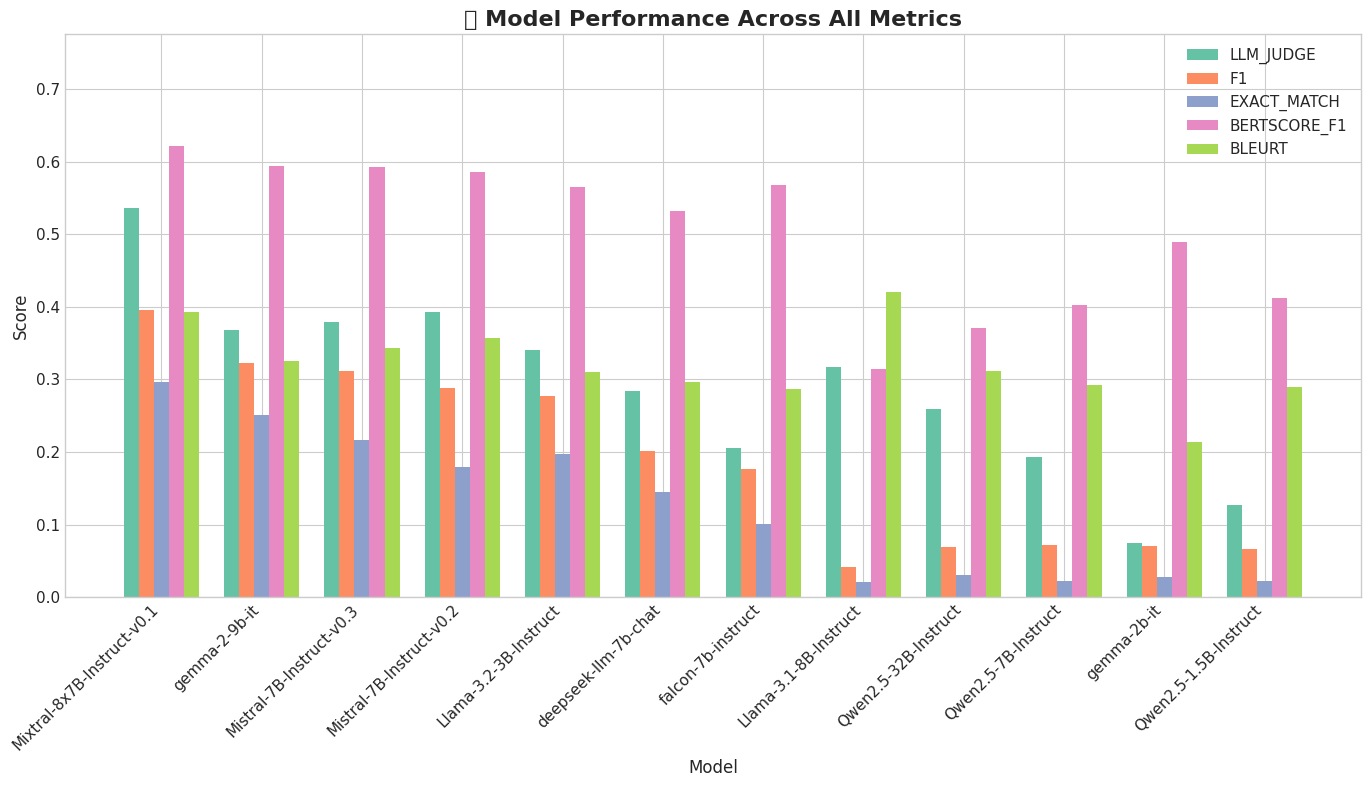

In [44]:
# Visual leaderboard - all metrics side by side
fig, ax = plt.subplots(figsize=(14, 8))

models = leaderboard.index.tolist()
x = np.arange(len(models))
width = 0.15

for i, metric in enumerate(METRICS):
    col = f'{metric}_mean'
    if col in leaderboard.columns:
        values = leaderboard[col].values
        bars = ax.bar(x + i * width, values, width, label=metric.upper(), color=METRIC_PALETTE[i])

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('🏆 Model Performance Across All Metrics', fontsize=16, fontweight='bold')
ax.set_xticks(x + width * (len(METRICS) - 1) / 2)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.set_ylim(0, max(0.7, df[METRICS].max().max() * 1.1))

plt.tight_layout()
plt.show()

## 🔬 Model Sensitivity Analysis

Which models are **most susceptible to improvement** from RAG or prompt changes? Which are **stable** (don't change much)?

This helps identify:
- **High-potential models**: Could improve significantly with better RAG/prompts
- **Stable models**: Already optimized or insensitive to changes

In [45]:
# =============================================================================
# MODEL SENSITIVITY ANALYSIS - Which models improve with RAG/prompts?
# =============================================================================

def compute_model_sensitivity(metric='llm_judge'):
    """Compute how much each model changes with RAG vs Direct and different prompts."""
    if metric not in df.columns:
        metric = 'f1'
    
    sensitivity_data = []
    
    for model in df['model_short'].unique():
        model_df = df[df['model_short'] == model]
        
        # RAG sensitivity: RAG mean - Direct mean
        direct_vals = model_df[model_df['type'] == 'direct'][metric].dropna()
        rag_vals = model_df[model_df['type'] == 'rag'][metric].dropna()
        
        rag_effect = rag_vals.mean() - direct_vals.mean() if len(direct_vals) > 0 and len(rag_vals) > 0 else 0
        rag_pct = (rag_effect / direct_vals.mean() * 100) if len(direct_vals) > 0 and direct_vals.mean() > 0 else 0
        
        # Prompt sensitivity: difference between best and worst prompt
        prompt_means = model_df.groupby('prompt')[metric].mean()
        prompt_effect = prompt_means.max() - prompt_means.min() if len(prompt_means) > 1 else 0
        best_prompt = prompt_means.idxmax() if len(prompt_means) > 0 else 'N/A'
        
        # Overall variance (how much does this model vary?)
        overall_std = model_df[metric].std() if len(model_df) > 1 else 0
        
        sensitivity_data.append({
            'model': model,
            'n_experiments': len(model_df),
            'n_direct': len(direct_vals),
            'n_rag': len(rag_vals),
            'direct_mean': direct_vals.mean() if len(direct_vals) > 0 else 0,
            'rag_mean': rag_vals.mean() if len(rag_vals) > 0 else 0,
            'rag_effect': rag_effect,
            'rag_effect_pct': rag_pct,
            'rag_helps': rag_effect > 0,
            'prompt_effect': prompt_effect,
            'best_prompt': best_prompt,
            'overall_std': overall_std,
        })
    
    return pd.DataFrame(sensitivity_data).sort_values('rag_effect', ascending=False)

# Compute sensitivity for primary metric
sensitivity = compute_model_sensitivity(PRIMARY_METRIC)

print(f'🔬 MODEL SENSITIVITY ANALYSIS ({PRIMARY_METRIC.upper()})')
print('=' * 100)

🔬 MODEL SENSITIVITY ANALYSIS (LLM_JUDGE)


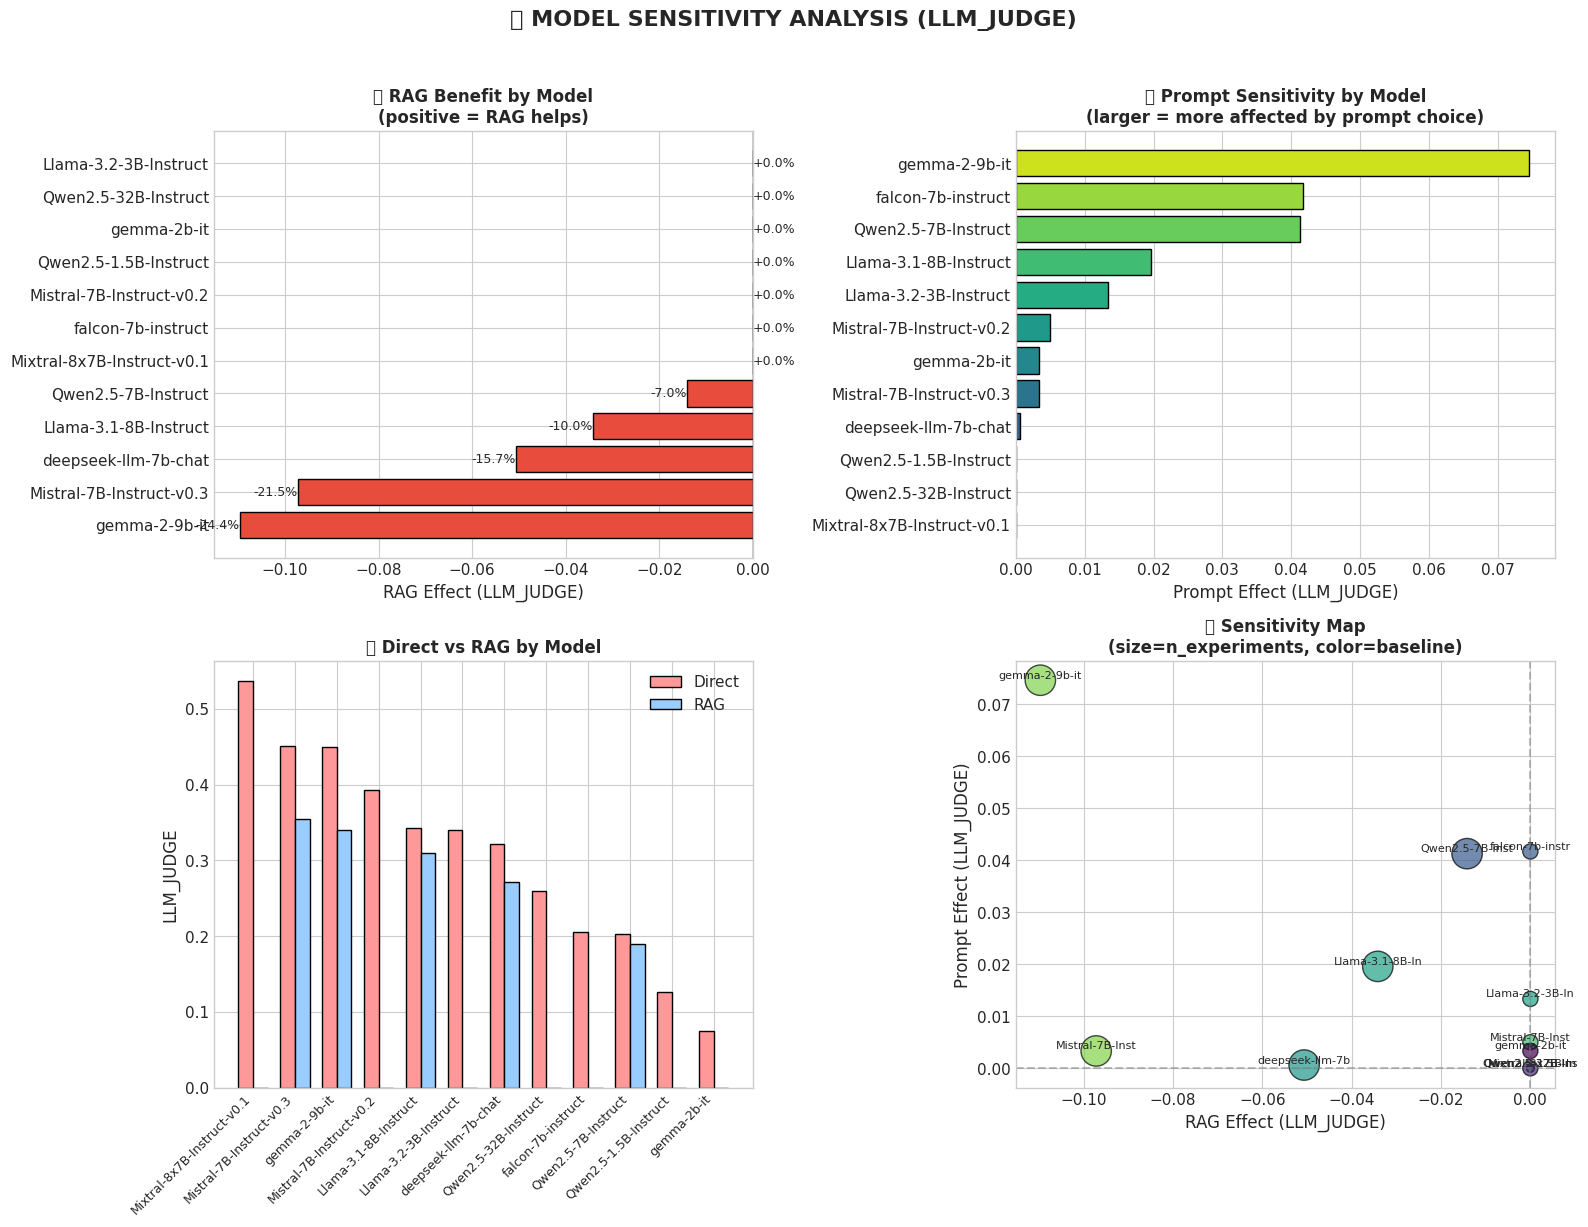

In [46]:
# Visualize RAG sensitivity by model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RAG Effect by Model (sorted)
ax = axes[0, 0]
sens_sorted = sensitivity.sort_values('rag_effect', ascending=True)
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in sens_sorted['rag_effect']]
bars = ax.barh(sens_sorted['model'], sens_sorted['rag_effect'], color=colors, edgecolor='black')
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel(f'RAG Effect ({PRIMARY_METRIC.upper()})')
ax.set_title('📈 RAG Benefit by Model\n(positive = RAG helps)', fontsize=12, fontweight='bold')
for bar, pct in zip(bars, sens_sorted['rag_effect_pct']):
    x_pos = bar.get_width()
    ax.annotate(f'{pct:+.1f}%', xy=(x_pos, bar.get_y() + bar.get_height()/2),
               ha='left' if x_pos >= 0 else 'right', va='center', fontsize=9)

# 2. Prompt Effect by Model (sorted)
ax = axes[0, 1]
sens_sorted = sensitivity.sort_values('prompt_effect', ascending=True)
colors = sns.color_palette('viridis', len(sens_sorted))
bars = ax.barh(sens_sorted['model'], sens_sorted['prompt_effect'], color=colors, edgecolor='black')
ax.set_xlabel(f'Prompt Effect ({PRIMARY_METRIC.upper()})')
ax.set_title('📝 Prompt Sensitivity by Model\n(larger = more affected by prompt choice)', fontsize=12, fontweight='bold')

# 3. Direct vs RAG comparison per model
ax = axes[1, 0]
x = np.arange(len(sensitivity))
width = 0.35
sens_sorted = sensitivity.sort_values('direct_mean', ascending=False)
ax.bar(x - width/2, sens_sorted['direct_mean'], width, label='Direct', color='#ff9999', edgecolor='black')
ax.bar(x + width/2, sens_sorted['rag_mean'], width, label='RAG', color='#99ccff', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(sens_sorted['model'], rotation=45, ha='right', fontsize=9)
ax.set_ylabel(PRIMARY_METRIC.upper())
ax.set_title('🔄 Direct vs RAG by Model', fontsize=12, fontweight='bold')
ax.legend()

# 4. Scatter: RAG effect vs Prompt effect (find high-potential models)
ax = axes[1, 1]
ax.scatter(sensitivity['rag_effect'], sensitivity['prompt_effect'], 
           s=sensitivity['n_experiments']*10, alpha=0.7, c=sensitivity['direct_mean'], 
           cmap='viridis', edgecolor='black')
for _, row in sensitivity.iterrows():
    ax.annotate(row['model'][:15], xy=(row['rag_effect'], row['prompt_effect']),
               fontsize=8, ha='center', va='bottom')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel(f'RAG Effect ({PRIMARY_METRIC.upper()})')
ax.set_ylabel(f'Prompt Effect ({PRIMARY_METRIC.upper()})')
ax.set_title('🎯 Sensitivity Map\n(size=n_experiments, color=baseline)', fontsize=12, fontweight='bold')

plt.suptitle(f'🔬 MODEL SENSITIVITY ANALYSIS ({PRIMARY_METRIC.upper()})', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [47]:
# Categorize models by sensitivity
def categorize_model(row):
    """Categorize model based on RAG and prompt sensitivity."""
    rag_high = abs(row['rag_effect']) > 0.02  # More than 2% change
    prompt_high = row['prompt_effect'] > 0.02
    
    if row['rag_effect'] > 0.02:
        if prompt_high:
            return '🚀 High Potential (RAG+Prompt help)'
        return '📈 RAG Responsive'
    elif row['rag_effect'] < -0.02:
        if prompt_high:
            return '⚠️ RAG Hurts but Prompt Sensitive'
        return '📉 RAG Hurts'
    else:
        if prompt_high:
            return '📝 Prompt Sensitive Only'
        return '🔒 Stable (insensitive)'

sensitivity['category'] = sensitivity.apply(categorize_model, axis=1)

# Summary by category
print('📊 MODEL CATEGORIES:')
print('=' * 80)
for cat in sensitivity['category'].unique():
    models = sensitivity[sensitivity['category'] == cat]['model'].tolist()
    print(f'\n{cat}:')
    for m in models:
        row = sensitivity[sensitivity['model'] == m].iloc[0]
        print(f'  • {m}: RAG={row["rag_effect"]:+.4f} ({row["rag_effect_pct"]:+.1f}%), Prompt={row["prompt_effect"]:.4f}')

# Display full sensitivity table
print('\n\n📋 FULL SENSITIVITY TABLE:')
display(sensitivity[['model', 'n_experiments', 'direct_mean', 'rag_mean', 'rag_effect', 'rag_effect_pct', 
                     'prompt_effect', 'best_prompt', 'category']].style.format({
    'direct_mean': '{:.4f}', 'rag_mean': '{:.4f}', 'rag_effect': '{:+.4f}', 
    'rag_effect_pct': '{:+.1f}%', 'prompt_effect': '{:.4f}'
}).background_gradient(subset=['rag_effect'], cmap='RdYlGn', vmin=-0.1, vmax=0.1))

📊 MODEL CATEGORIES:

🔒 Stable (insensitive):
  • Mixtral-8x7B-Instruct-v0.1: RAG=+0.0000 (+0.0%), Prompt=0.0000
  • Mistral-7B-Instruct-v0.2: RAG=+0.0000 (+0.0%), Prompt=0.0050
  • Llama-3.2-3B-Instruct: RAG=+0.0000 (+0.0%), Prompt=0.0133
  • Qwen2.5-32B-Instruct: RAG=+0.0000 (+0.0%), Prompt=0.0000
  • gemma-2b-it: RAG=+0.0000 (+0.0%), Prompt=0.0033
  • Qwen2.5-1.5B-Instruct: RAG=+0.0000 (+0.0%), Prompt=0.0000

📝 Prompt Sensitive Only:
  • falcon-7b-instruct: RAG=+0.0000 (+0.0%), Prompt=0.0417
  • Qwen2.5-7B-Instruct: RAG=-0.0142 (-7.0%), Prompt=0.0413

📉 RAG Hurts:
  • Llama-3.1-8B-Instruct: RAG=-0.0342 (-10.0%), Prompt=0.0196
  • deepseek-llm-7b-chat: RAG=-0.0507 (-15.7%), Prompt=0.0006
  • Mistral-7B-Instruct-v0.3: RAG=-0.0972 (-21.5%), Prompt=0.0033

⚠️ RAG Hurts but Prompt Sensitive:
  • gemma-2-9b-it: RAG=-0.1097 (-24.4%), Prompt=0.0746


📋 FULL SENSITIVITY TABLE:


,model,n_experiments,direct_mean,rag_mean,rag_effect,rag_effect_pct,prompt_effect,best_prompt,category
1,Mixtral-8x7B-Instruct-v0.1,3,0.5367,0.0000,+0.0000,+0.0%,0.0000,concise,🔒 Stable (insensitive)
3,Mistral-7B-Instruct-v0.2,12,0.3925,0.0000,+0.0000,+0.0%,0.0050,fewshot,🔒 Stable (insensitive)
6,falcon-7b-instruct,12,0.2058,0.0000,+0.0000,+0.0%,0.0417,fewshot,📝 Prompt Sensitive Only
4,Llama-3.2-3B-Instruct,12,0.3400,0.0000,+0.0000,+0.0%,0.0133,fewshot,🔒 Stable (insensitive)
11,Qwen2.5-32B-Instruct,3,0.2600,0.0000,+0.0000,+0.0%,0.0000,concise,🔒 Stable (insensitive)
9,gemma-2b-it,12,0.0750,0.0000,+0.0000,+0.0%,0.0033,concise,🔒 Stable (insensitive)
10,Qwen2.5-1.5B-Instruct,12,0.1267,0.0000,+0.0000,+0.0%,0.0000,concise,🔒 Stable (insensitive)
7,Qwen2.5-7B-Instruct,48,0.2033,0.1892,-0.0142,-7.0%,0.0413,fewshot,📝 Prompt Sensitive Only
8,Llama-3.1-8B-Instruct,48,0.3433,0.3092,-0.0342,-10.0%,0.0196,fewshot,📉 RAG Hurts
5,deepseek-llm-7b-chat,48,0.3220,0.2713,-0.0507,-15.7%,0.0006,fewshot,📉 RAG Hurts


In [48]:
# Deep dive: Best and worst models for improvement
print('🔍 DEEP DIVE: Top models for each category')
print('=' * 80)

# Models that benefit MOST from RAG
print('\n📈 TOP 3 MODELS THAT BENEFIT FROM RAG:')
top_rag = sensitivity.nlargest(3, 'rag_effect')
for _, row in top_rag.iterrows():
    print(f'\n  🏆 {row["model"]}')
    print(f'     Direct → RAG: {row["direct_mean"]:.4f} → {row["rag_mean"]:.4f} ({row["rag_effect_pct"]:+.1f}%)')
    print(f'     Best prompt: {row["best_prompt"]}')
    print(f'     n={row["n_experiments"]} experiments')

# Models that are HURT by RAG
print('\n\n📉 TOP 3 MODELS HURT BY RAG:')
worst_rag = sensitivity.nsmallest(3, 'rag_effect')
for _, row in worst_rag.iterrows():
    print(f'\n  ⚠️ {row["model"]}')
    print(f'     Direct → RAG: {row["direct_mean"]:.4f} → {row["rag_mean"]:.4f} ({row["rag_effect_pct"]:+.1f}%)')
    print(f'     Recommendation: Consider using direct LLM only')

# Most stable models
print('\n\n🔒 MOST STABLE MODELS (low variance):')
stable = sensitivity.nsmallest(3, 'overall_std')
for _, row in stable.iterrows():
    print(f'\n  🔒 {row["model"]}')
    print(f'     Std dev: {row["overall_std"]:.4f}')
    print(f'     Already optimized or insensitive to changes')

# Most variable models
print('\n\n🎲 MOST VARIABLE MODELS (high variance):')
variable = sensitivity.nlargest(3, 'overall_std')
for _, row in variable.iterrows():
    print(f'\n  🎲 {row["model"]}')
    print(f'     Std dev: {row["overall_std"]:.4f}')
    print(f'     High potential for optimization')

🔍 DEEP DIVE: Top models for each category

📈 TOP 3 MODELS THAT BENEFIT FROM RAG:

  🏆 Mixtral-8x7B-Instruct-v0.1
     Direct → RAG: 0.5367 → 0.0000 (+0.0%)
     Best prompt: concise
     n=3 experiments

  🏆 Mistral-7B-Instruct-v0.2
     Direct → RAG: 0.3925 → 0.0000 (+0.0%)
     Best prompt: fewshot
     n=12 experiments

  🏆 falcon-7b-instruct
     Direct → RAG: 0.2058 → 0.0000 (+0.0%)
     Best prompt: fewshot
     n=12 experiments


📉 TOP 3 MODELS HURT BY RAG:

  ⚠️ gemma-2-9b-it
     Direct → RAG: 0.4500 → 0.3403 (-24.4%)
     Recommendation: Consider using direct LLM only

  ⚠️ Mistral-7B-Instruct-v0.3
     Direct → RAG: 0.4517 → 0.3544 (-21.5%)
     Recommendation: Consider using direct LLM only

  ⚠️ deepseek-llm-7b-chat
     Direct → RAG: 0.3220 → 0.2713 (-15.7%)
     Recommendation: Consider using direct LLM only


🔒 MOST STABLE MODELS (low variance):

  🔒 gemma-2b-it
     Std dev: 0.0297
     Already optimized or insensitive to changes

  🔒 Qwen2.5-1.5B-Instruct
     Std dev

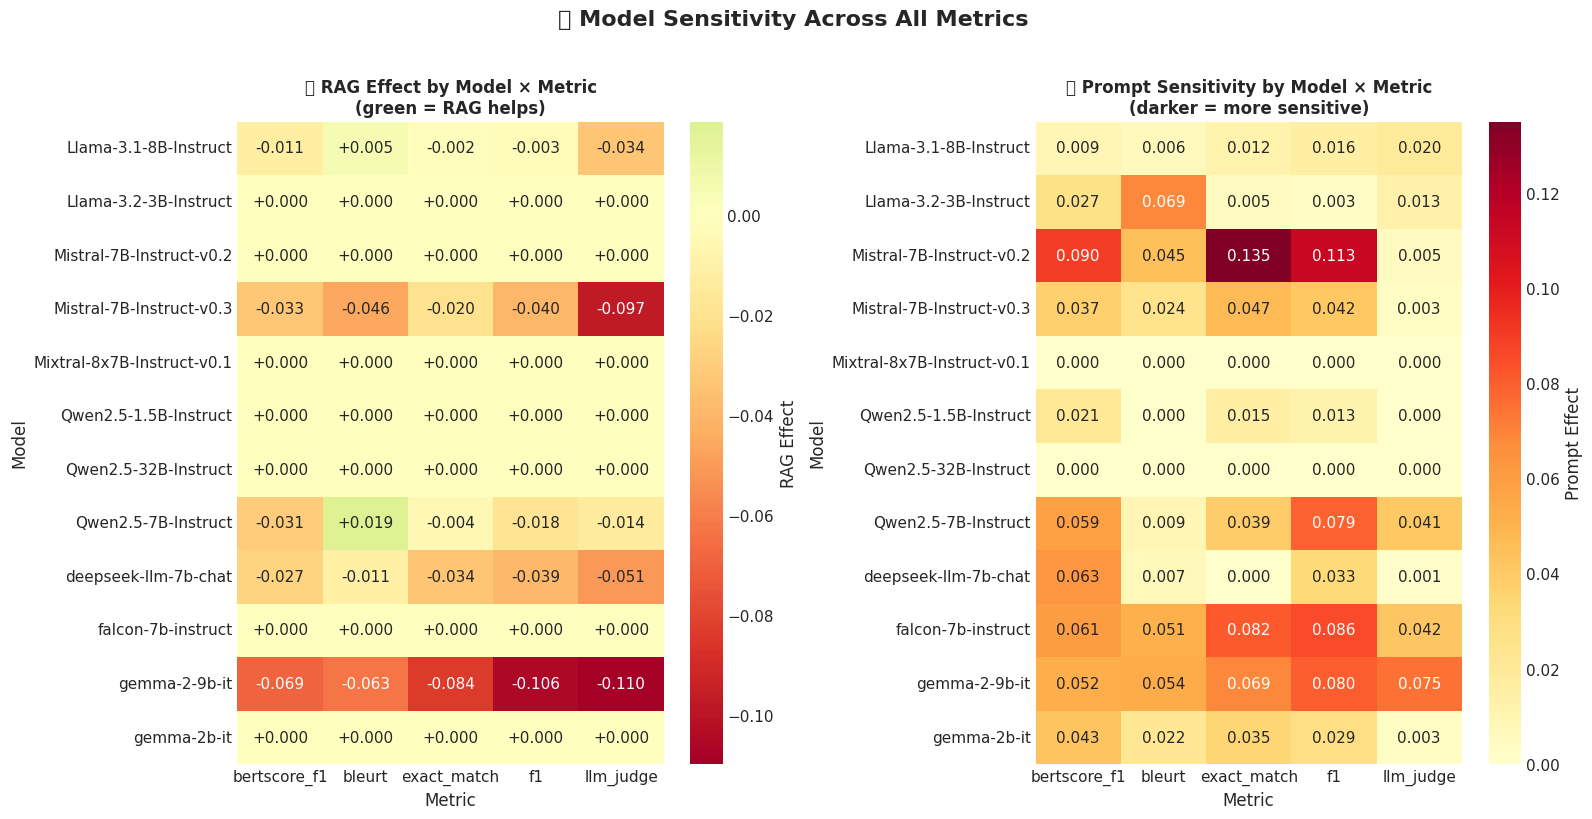

In [49]:
# Heatmap: Model sensitivity across all metrics
def compute_multi_metric_sensitivity():
    """Compute sensitivity for all metrics."""
    all_sens = []
    for metric in METRICS:
        if metric not in df.columns:
            continue
        sens = compute_model_sensitivity(metric)
        sens['metric'] = metric
        all_sens.append(sens[['model', 'rag_effect', 'prompt_effect', 'metric']])
    return pd.concat(all_sens, ignore_index=True)

multi_sens = compute_multi_metric_sensitivity()

# Pivot for heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# RAG effect heatmap
ax = axes[0]
rag_pivot = multi_sens.pivot(index='model', columns='metric', values='rag_effect')
sns.heatmap(rag_pivot, annot=True, fmt='+.3f', cmap='RdYlGn', center=0, ax=ax,
            cbar_kws={'label': 'RAG Effect'})
ax.set_title('📈 RAG Effect by Model × Metric\n(green = RAG helps)', fontsize=12, fontweight='bold')
ax.set_xlabel('Metric')
ax.set_ylabel('Model')

# Prompt effect heatmap
ax = axes[1]
prompt_pivot = multi_sens.pivot(index='model', columns='metric', values='prompt_effect')
sns.heatmap(prompt_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax,
            cbar_kws={'label': 'Prompt Effect'})
ax.set_title('📝 Prompt Sensitivity by Model × Metric\n(darker = more sensitive)', fontsize=12, fontweight='bold')
ax.set_xlabel('Metric')
ax.set_ylabel('Model')

plt.suptitle('🔬 Model Sensitivity Across All Metrics', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 📏 Performance vs Model Size

Does model size (number of parameters) correlate with performance? Does RAG help smaller models catch up?

In [50]:
# =============================================================================
# PERFORMANCE VS MODEL SIZE - Map models to parameter counts
# =============================================================================

# Parameter counts for common models (in billions)
MODEL_PARAMS = {
    # Gemma family
    'gemma-2b-it': 2.0,
    'gemma-2-9b-it': 9.0,
    'gemma-7b-it': 7.0,
    
    # Llama family
    'Llama-3.1-8B-Instruct': 8.0,
    'Llama-3.2-3B-Instruct': 3.0,
    'Llama-3.2-1B-Instruct': 1.0,
    'Llama-2-7b-chat': 7.0,
    'Llama-2-13b-chat': 13.0,
    
    # Mistral family
    'Mistral-7B-Instruct-v0.2': 7.0,
    'Mistral-7B-Instruct-v0.3': 7.0,
    'Mixtral-8x7B-Instruct-v0.1': 46.7,  # 8 experts x 7B, but ~13B active
    
    # Qwen family
    'Qwen2.5-1.5B-Instruct': 1.5,
    'Qwen2.5-7B-Instruct': 7.0,
    'Qwen2.5-32B-Instruct': 32.0,
    'Qwen2.5-72B-Instruct': 72.0,
    
    # DeepSeek
    'deepseek-llm-7b-chat': 7.0,
    
    # Falcon
    'falcon-7b-instruct': 7.0,
    
    # Phi
    'phi-3-mini-4k-instruct': 3.8,
    'phi-2': 2.7,
}

# Map model names to params (handle partial matches)
def get_model_params(model_name):
    """Get parameter count for a model, with fuzzy matching."""
    # Exact match
    if model_name in MODEL_PARAMS:
        return MODEL_PARAMS[model_name]
    
    # Partial match
    for key, params in MODEL_PARAMS.items():
        if key.lower() in model_name.lower() or model_name.lower() in key.lower():
            return params
    
    # Try to extract from name (e.g., "7b", "13b")
    import re
    match = re.search(r'(\d+\.?\d*)b', model_name.lower())
    if match:
        return float(match.group(1))
    
    return None

# Add params to dataframe
df['params_b'] = df['model_short'].apply(get_model_params)

# Check coverage
known = df['params_b'].notna().sum()
total = len(df)
print(f'📏 MODEL SIZE MAPPING')
print('=' * 60)
print(f'Mapped {known}/{total} experiments to parameter counts')
print()

# Show mapping
param_map = df.groupby('model_short')['params_b'].first().dropna().sort_values()
print('Model → Parameters (B):')
for model, params in param_map.items():
    print(f'  {model}: {params}B')

📏 MODEL SIZE MAPPING
Mapped 306/306 experiments to parameter counts

Model → Parameters (B):
  Qwen2.5-1.5B-Instruct: 1.5B
  gemma-2b-it: 2.0B
  Llama-3.2-3B-Instruct: 3.0B
  Mistral-7B-Instruct-v0.3: 7.0B
  Qwen2.5-7B-Instruct: 7.0B
  falcon-7b-instruct: 7.0B
  deepseek-llm-7b-chat: 7.0B
  Mistral-7B-Instruct-v0.2: 7.0B
  Llama-3.1-8B-Instruct: 8.0B
  gemma-2-9b-it: 9.0B
  Qwen2.5-32B-Instruct: 32.0B
  Mixtral-8x7B-Instruct-v0.1: 46.7B


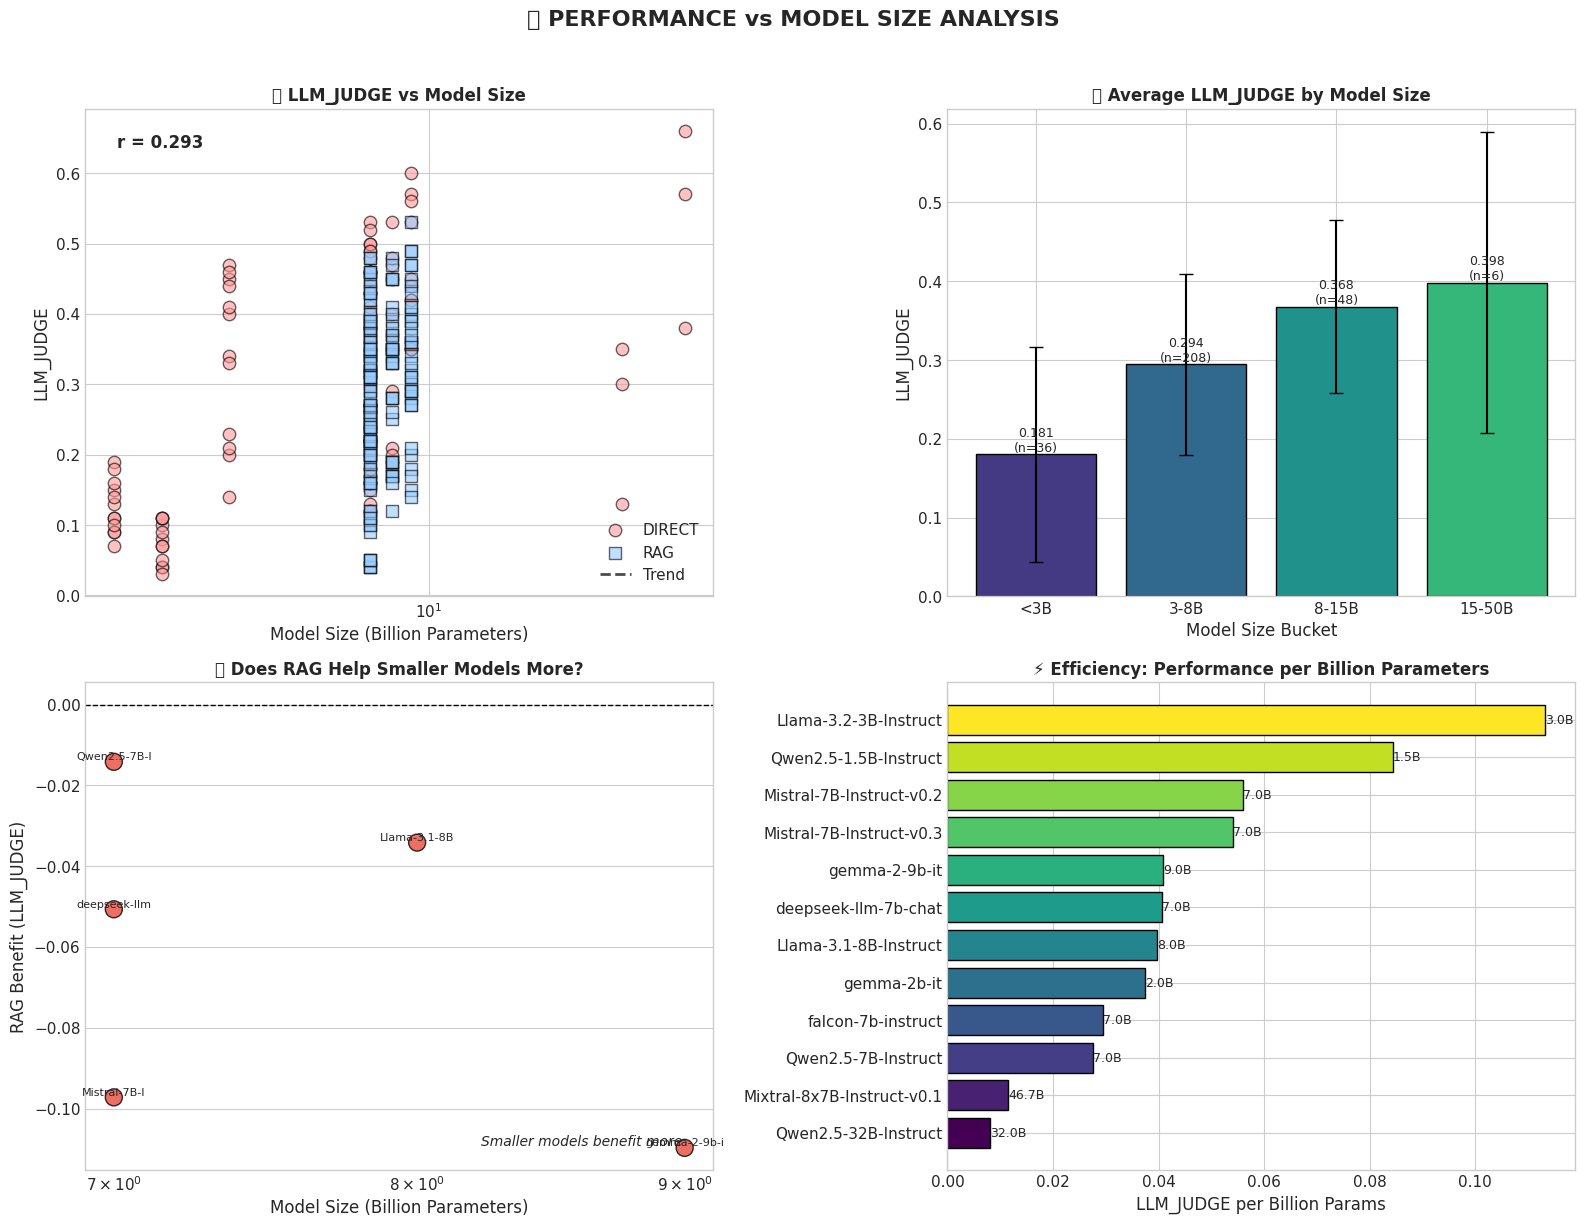

In [51]:
# Visualize performance vs model size
df_with_params = df[df['params_b'].notna()].copy()

if len(df_with_params) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Scatter: Model size vs LLM Judge (all experiments)
    ax = axes[0, 0]
    for exp_type, color, marker in [('direct', '#ff9999', 'o'), ('rag', '#99ccff', 's')]:
        subset = df_with_params[df_with_params['type'] == exp_type]
        ax.scatter(subset['params_b'], subset[PRIMARY_METRIC], alpha=0.6, 
                   c=color, marker=marker, s=80, label=exp_type.upper(), edgecolor='black')
    
    # Add trend line
    z = np.polyfit(df_with_params['params_b'], df_with_params[PRIMARY_METRIC], 1)
    p_fn = np.poly1d(z)
    x_line = np.linspace(df_with_params['params_b'].min(), df_with_params['params_b'].max(), 100)
    ax.plot(x_line, p_fn(x_line), 'k--', alpha=0.7, linewidth=2, label='Trend')
    
    ax.set_xlabel('Model Size (Billion Parameters)')
    ax.set_ylabel(PRIMARY_METRIC.upper())
    ax.set_title(f'📏 {PRIMARY_METRIC.upper()} vs Model Size', fontsize=12, fontweight='bold')
    ax.legend()
    ax.set_xscale('log')
    
    # Add correlation
    corr = df_with_params['params_b'].corr(df_with_params[PRIMARY_METRIC])
    ax.annotate(f'r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
               fontsize=12, fontweight='bold', va='top')
    
    # 2. Average performance by model size bucket
    ax = axes[0, 1]
    df_with_params['size_bucket'] = pd.cut(df_with_params['params_b'], 
                                            bins=[0, 3, 8, 15, 50, 100],
                                            labels=['<3B', '3-8B', '8-15B', '15-50B', '>50B'])
    
    bucket_stats = df_with_params.groupby('size_bucket')[PRIMARY_METRIC].agg(['mean', 'std', 'count'])
    
    bars = ax.bar(bucket_stats.index.astype(str), bucket_stats['mean'], 
                  yerr=bucket_stats['std'], capsize=5,
                  color=sns.color_palette('viridis', len(bucket_stats)), edgecolor='black')
    ax.set_xlabel('Model Size Bucket')
    ax.set_ylabel(PRIMARY_METRIC.upper())
    ax.set_title(f'📊 Average {PRIMARY_METRIC.upper()} by Model Size', fontsize=12, fontweight='bold')
    for bar, (_, row) in zip(bars, bucket_stats.iterrows()):
        ax.annotate(f'{row["mean"]:.3f}\n(n={int(row["count"])})', 
                   xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   ha='center', va='bottom', fontsize=9)
    
    # 3. RAG benefit by model size
    ax = axes[1, 0]
    size_rag_benefit = []
    for model in df_with_params['model_short'].unique():
        model_df = df_with_params[df_with_params['model_short'] == model]
        params = model_df['params_b'].iloc[0]
        
        direct = model_df[model_df['type'] == 'direct'][PRIMARY_METRIC].mean()
        rag = model_df[model_df['type'] == 'rag'][PRIMARY_METRIC].mean()
        
        if not np.isnan(direct) and not np.isnan(rag):
            size_rag_benefit.append({
                'model': model,
                'params_b': params,
                'rag_benefit': rag - direct,
                'rag_benefit_pct': ((rag - direct) / direct * 100) if direct > 0 else 0
            })
    
    srb_df = pd.DataFrame(size_rag_benefit)
    if len(srb_df) > 0:
        colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in srb_df['rag_benefit']]
        ax.scatter(srb_df['params_b'], srb_df['rag_benefit'], c=colors, s=150, edgecolor='black', alpha=0.8)
        
        for _, row in srb_df.iterrows():
            ax.annotate(row['model'][:12], xy=(row['params_b'], row['rag_benefit']),
                       fontsize=8, ha='center', va='bottom')
        
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.set_xlabel('Model Size (Billion Parameters)')
        ax.set_ylabel(f'RAG Benefit ({PRIMARY_METRIC.upper()})')
        ax.set_title('🔄 Does RAG Help Smaller Models More?', fontsize=12, fontweight='bold')
        ax.set_xscale('log')
        
        # Add trend
        z = np.polyfit(np.log10(srb_df['params_b']), srb_df['rag_benefit'], 1)
        trend_text = 'Smaller models benefit more' if z[0] < 0 else 'Larger models benefit more'
        ax.annotate(trend_text, xy=(0.95, 0.05), xycoords='axes fraction',
                   ha='right', fontsize=10, style='italic')
    
    # 4. Efficiency: Performance per billion params
    ax = axes[1, 1]
    df_with_params['efficiency'] = df_with_params[PRIMARY_METRIC] / df_with_params['params_b']
    
    eff_by_model = df_with_params.groupby('model_short').agg({
        'efficiency': 'mean',
        'params_b': 'first',
        PRIMARY_METRIC: 'mean'
    }).sort_values('efficiency', ascending=True)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(eff_by_model)))
    bars = ax.barh(eff_by_model.index, eff_by_model['efficiency'], color=colors, edgecolor='black')
    ax.set_xlabel(f'{PRIMARY_METRIC.upper()} per Billion Params')
    ax.set_title('⚡ Efficiency: Performance per Billion Parameters', fontsize=12, fontweight='bold')
    
    for bar, (model, row) in zip(bars, eff_by_model.iterrows()):
        ax.annotate(f'{row["params_b"]:.1f}B', xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                   ha='left', va='center', fontsize=9)
    
    plt.suptitle('📏 PERFORMANCE vs MODEL SIZE ANALYSIS', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ No models with known parameter counts found')

In [52]:
# Summary: Model size analysis
if len(df_with_params) > 0:
    print('📏 MODEL SIZE ANALYSIS SUMMARY')
    print('=' * 80)
    
    # Correlation between size and performance
    for metric in METRICS:
        if metric in df_with_params.columns:
            corr = df_with_params['params_b'].corr(df_with_params[metric])
            strength = 'Strong' if abs(corr) > 0.5 else 'Moderate' if abs(corr) > 0.3 else 'Weak'
            direction = 'positive' if corr > 0 else 'negative'
            print(f'{metric.upper():15} vs Size: r={corr:+.3f} ({strength} {direction})')
    
    # Best value models (high performance, low params)
    print('\n🏆 BEST VALUE MODELS (high performance / low params):')
    value_score = df_with_params.groupby('model_short').agg({
        PRIMARY_METRIC: 'mean',
        'params_b': 'first'
    })
    value_score['value'] = value_score[PRIMARY_METRIC] / np.log10(value_score['params_b'] + 1)
    best_value = value_score.nlargest(5, 'value')
    
    for model, row in best_value.iterrows():
        print(f'  • {model}: {row[PRIMARY_METRIC]:.4f} {PRIMARY_METRIC.upper()} with only {row["params_b"]}B params')
    
    # Does RAG close the gap?
    print('\n🔄 RAG IMPACT BY MODEL SIZE:')
    if 'size_bucket' in df_with_params.columns:
        for bucket in df_with_params['size_bucket'].dropna().unique():
            bucket_df = df_with_params[df_with_params['size_bucket'] == bucket]
            direct = bucket_df[bucket_df['type'] == 'direct'][PRIMARY_METRIC].mean()
            rag = bucket_df[bucket_df['type'] == 'rag'][PRIMARY_METRIC].mean()
            if not np.isnan(direct) and not np.isnan(rag):
                diff = rag - direct
                emoji = '📈' if diff > 0 else '📉'
                print(f'  {bucket}: Direct={direct:.4f}, RAG={rag:.4f}, Δ={diff:+.4f} {emoji}')
    
    # Summary table
    print('\n📋 FULL SIZE-PERFORMANCE TABLE:')
    size_summary = df_with_params.groupby('model_short').agg({
        'params_b': 'first',
        PRIMARY_METRIC: ['mean', 'std'],
        'type': lambda x: (x == 'rag').sum()
    }).round(4)
    size_summary.columns = ['Params (B)', f'{PRIMARY_METRIC}_mean', f'{PRIMARY_METRIC}_std', 'RAG_count']
    size_summary = size_summary.sort_values('Params (B)')
    display(size_summary.style.background_gradient(subset=[f'{PRIMARY_METRIC}_mean'], cmap='RdYlGn'))

📏 MODEL SIZE ANALYSIS SUMMARY
LLM_JUDGE       vs Size: r=+0.293 (Weak positive)
F1              vs Size: r=+0.156 (Weak positive)
EXACT_MATCH     vs Size: r=+0.162 (Weak positive)
BERTSCORE_F1    vs Size: r=+0.050 (Weak positive)
BLEURT          vs Size: r=+0.230 (Weak positive)

🏆 BEST VALUE MODELS (high performance / low params):
  • Llama-3.2-3B-Instruct: 0.3400 LLM_JUDGE with only 3.0B params
  • Mistral-7B-Instruct-v0.2: 0.3925 LLM_JUDGE with only 7.0B params
  • Mistral-7B-Instruct-v0.3: 0.3787 LLM_JUDGE with only 7.0B params
  • gemma-2-9b-it: 0.3677 LLM_JUDGE with only 9.0B params
  • Llama-3.1-8B-Instruct: 0.3177 LLM_JUDGE with only 8.0B params

🔄 RAG IMPACT BY MODEL SIZE:
  8-15B: Direct=0.4500, RAG=0.3403, Δ=-0.1097 📉
  3-8B: Direct=0.3197, RAG=0.2814, Δ=-0.0383 📉

📋 FULL SIZE-PERFORMANCE TABLE:


,Params (B),llm_judge_mean,llm_judge_std,RAG_count
model_short,,,,
Qwen2.5-1.5B-Instruct,1.500000,0.126700,0.038000,0
gemma-2b-it,2.000000,0.075000,0.029700,0
Llama-3.2-3B-Instruct,3.000000,0.340000,0.117000,0
Mistral-7B-Instruct-v0.3,7.000000,0.378700,0.092500,36
Qwen2.5-7B-Instruct,7.000000,0.192700,0.086900,36
falcon-7b-instruct,7.000000,0.205800,0.040600,0
deepseek-llm-7b-chat,7.000000,0.284000,0.083100,36
Mistral-7B-Instruct-v0.2,7.000000,0.392500,0.056700,0
Llama-3.1-8B-Instruct,8.000000,0.317700,0.108400,36


## 3️⃣ Prompt Impact Analysis

Do different prompting strategies (default, concise, fewshot) affect results?

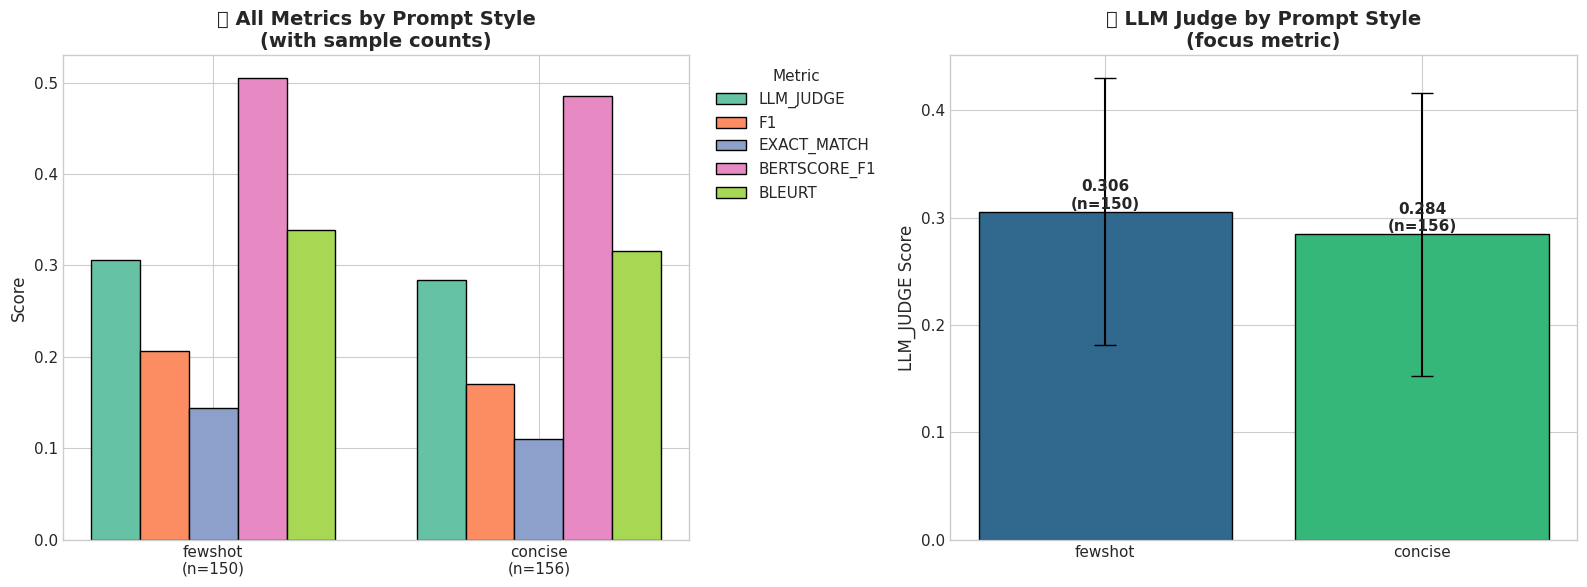


📊 Prompt Impact Summary:


,prompt,n,llm_judge_mean,llm_judge_std,f1_mean,f1_std,exact_match_mean,exact_match_std,bertscore_f1_mean,bertscore_f1_std,bleurt_mean,bleurt_std
0,fewshot,150,0.3056,0.1241,0.2063,0.1426,0.1441,0.1263,0.5046,0.1307,0.3384,0.0586
1,concise,156,0.2844,0.1318,0.1706,0.1292,0.1103,0.1083,0.4849,0.1061,0.3163,0.0600


In [53]:
# =============================================================================
# PROMPT IMPACT ANALYSIS - Visual comparison with sample counts
# =============================================================================

# Build prompt comparison data
prompt_data = []
for prompt in df['prompt'].unique():
    prompt_df = df[df['prompt'] == prompt]
    row = {'prompt': prompt, 'n': len(prompt_df)}
    for metric in METRICS:
        if metric in prompt_df.columns:
            row[f'{metric}_mean'] = prompt_df[metric].mean()
            row[f'{metric}_std'] = prompt_df[metric].std()
    prompt_data.append(row)
prompt_stats = pd.DataFrame(prompt_data)

# Create visual comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. All metrics by prompt (grouped bar)
ax = axes[0]
prompts = prompt_stats['prompt'].tolist()
x = np.arange(len(prompts))
width = 0.15
for i, metric in enumerate(METRICS):
    col = f'{metric}_mean'
    if col in prompt_stats.columns:
        ax.bar(x + i * width, prompt_stats[col], width, 
               label=metric.upper(), color=METRIC_PALETTE[i], edgecolor='black')
ax.set_xticks(x + width * (len(METRICS) - 1) / 2)
ax.set_xticklabels([f'{p}\n(n={n})' for p, n in zip(prompts, prompt_stats['n'])], fontsize=11)
ax.set_ylabel('Score')
ax.set_title('📝 All Metrics by Prompt Style\n(with sample counts)', fontsize=14, fontweight='bold')
ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')

# 2. LLM Judge focus with error bars
ax = axes[1]
if 'llm_judge_mean' in prompt_stats.columns:
    colors = sns.color_palette('viridis', len(prompts))
    bars = ax.bar(prompts, prompt_stats['llm_judge_mean'], 
                  yerr=prompt_stats['llm_judge_std'], capsize=8,
                  color=colors, edgecolor='black')
    for bar, n, mean in zip(bars, prompt_stats['n'], prompt_stats['llm_judge_mean']):
        ax.annotate(f'{mean:.3f}\n(n={n})', 
                   xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax.set_ylabel('LLM_JUDGE Score')
    ax.set_title('🎯 LLM Judge by Prompt Style\n(focus metric)', fontsize=14, fontweight='bold')
else:
    ax.text(0.5, 0.5, 'No LLM Judge data', ha='center', va='center', fontsize=14)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Statistical summary table
print('\n📊 Prompt Impact Summary:')
display(prompt_stats.style.format(lambda x: f'{x:.4f}' if isinstance(x, float) else x).background_gradient(
    subset=[f'{m}_mean' for m in METRICS if f'{m}_mean' in prompt_stats.columns], cmap='RdYlGn'))

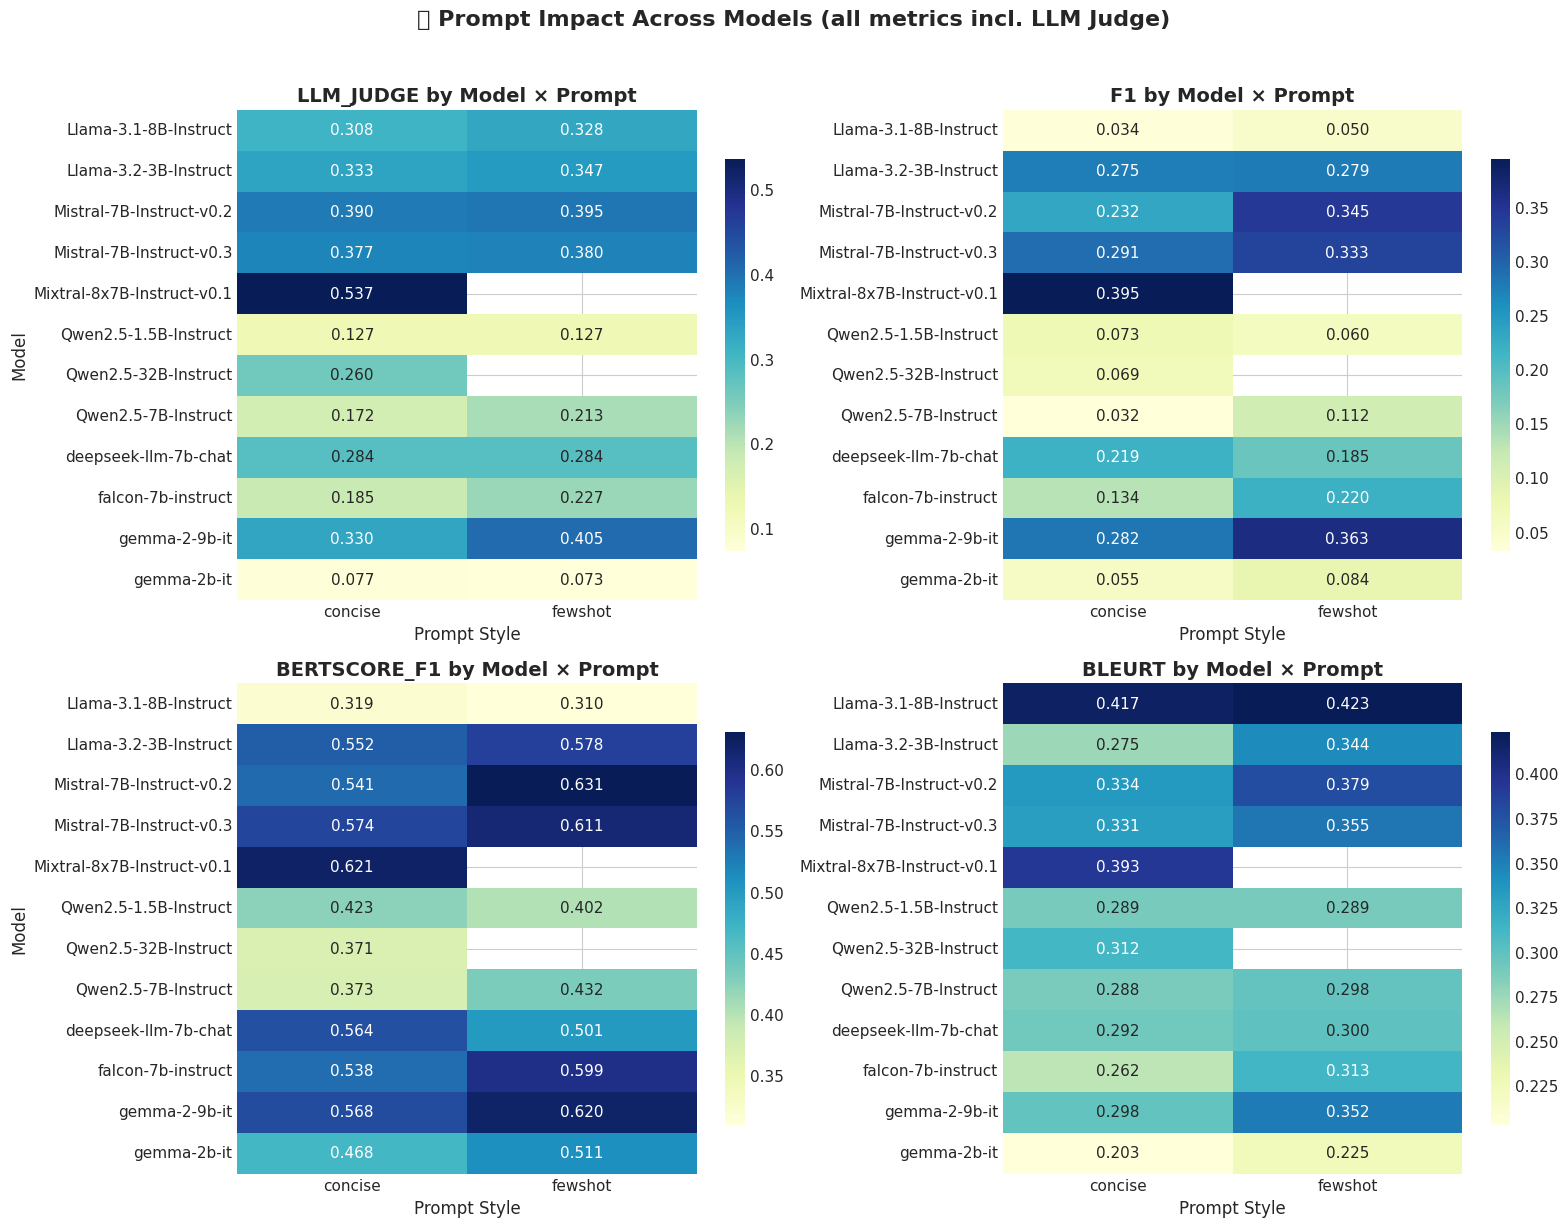

In [54]:
# Prompt × Model heatmap - Include LLM Judge
metrics_to_plot = ['llm_judge', 'f1', 'bertscore_f1', 'bleurt']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, metric in enumerate(metrics_to_plot):
    if metric not in df.columns:
        continue
    
    pivot = df.pivot_table(values=metric, index='model_short', columns='prompt', aggfunc='mean')
    counts = df.groupby(['model_short', 'prompt']).size().unstack(fill_value=0)
    
    ax = axes[i // 2, i % 2]
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, cbar_kws={'shrink': 0.8})
    ax.set_title(f'{metric.upper()} by Model × Prompt', fontweight='bold')
    ax.set_xlabel('Prompt Style')
    ax.set_ylabel('Model' if i % 2 == 0 else '')

plt.suptitle('📝 Prompt Impact Across Models (all metrics incl. LLM Judge)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

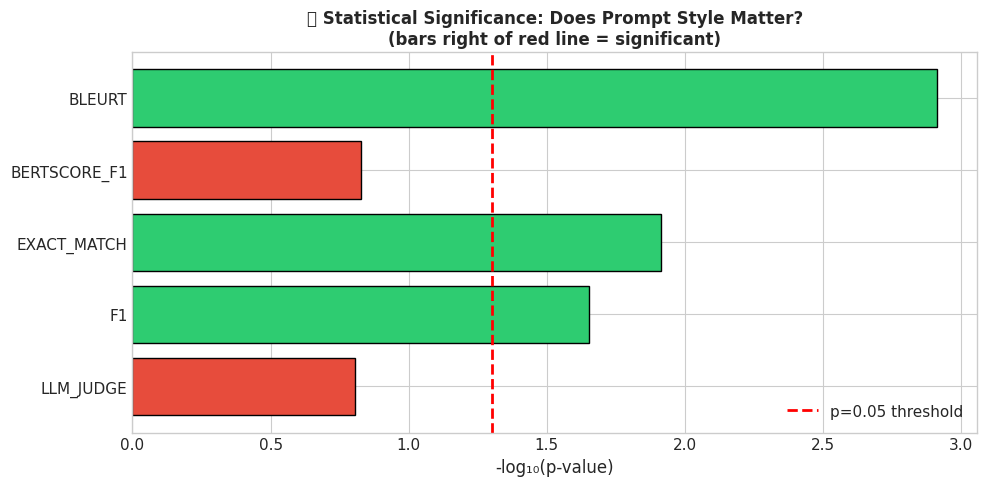

Statistical Test Results (ANOVA):


,metric,F_statistic,p_value,significant,effect
0,LLM_JUDGE,2.02,0.1560,False,No effect
1,F1,5.28,0.0223,True,Prompt matters
2,EXACT_MATCH,6.36,0.0122,True,Prompt matters
3,BERTSCORE_F1,2.09,0.1491,False,No effect
4,BLEURT,10.65,0.0012,True,Prompt matters


In [55]:
# Statistical test: Does prompt matter? (Include LLM Judge)
from scipy import stats as scipy_stats

# Build results for visualization
stat_results = []
for metric in METRICS:
    if metric not in df.columns:
        continue
    
    groups = [df[df['prompt'] == p][metric].dropna().values for p in df['prompt'].unique()]
    groups = [g for g in groups if len(g) > 0]
    
    if len(groups) >= 2:
        f_stat, p_val = scipy_stats.f_oneway(*groups)
        stat_results.append({
            'metric': metric.upper(),
            'F_statistic': f_stat,
            'p_value': p_val,
            'significant': p_val < 0.05,
            'effect': 'Prompt matters' if p_val < 0.05 else 'No effect'
        })

stat_df = pd.DataFrame(stat_results)

# Visualize statistical results
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2ecc71' if sig else '#e74c3c' for sig in stat_df['significant']]
bars = ax.barh(stat_df['metric'], -np.log10(stat_df['p_value']), color=colors, edgecolor='black')
ax.axvline(-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05 threshold')
ax.set_xlabel('-log₁₀(p-value)')
ax.set_title('📊 Statistical Significance: Does Prompt Style Matter?\n(bars right of red line = significant)', 
             fontsize=12, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

# Display table
print('Statistical Test Results (ANOVA):')
display(stat_df.style.format({'F_statistic': '{:.2f}', 'p_value': '{:.4f}'}).applymap(
    lambda x: 'background-color: #d4edda' if x == True else ('background-color: #f8d7da' if x == False else ''),
    subset=['significant']))

## 4️⃣ RAG vs Direct LLM Analysis

When does retrieval-augmented generation help? When does it hurt?

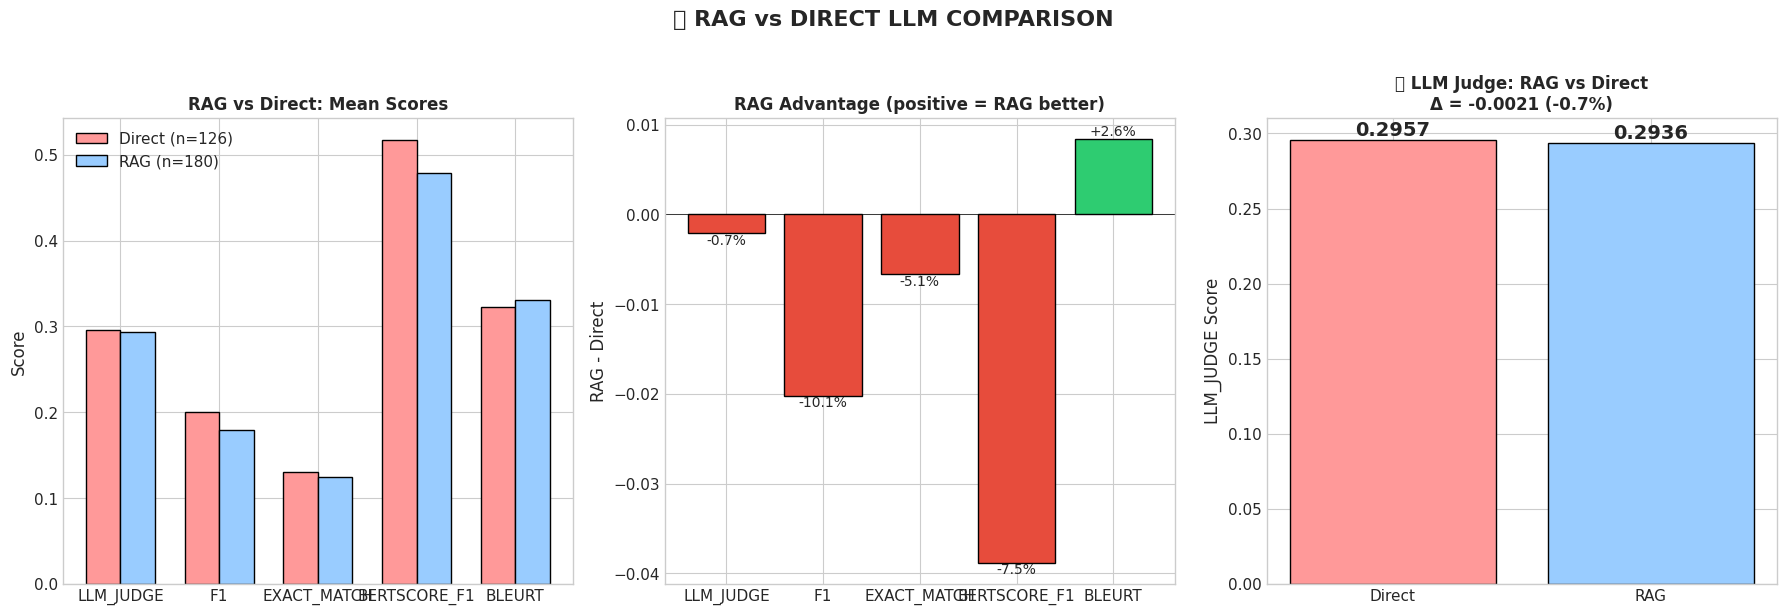

,metric,direct,rag,difference,pct_change,rag_better
0,LLM_JUDGE,0.2957,0.2936,-0.0021,-0.7%,False
1,F1,0.2000,0.1798,-0.0202,-10.1%,False
2,EXACT_MATCH,0.1308,0.1241,-0.0067,-5.1%,False
3,BERTSCORE_F1,0.5174,0.4786,-0.0388,-7.5%,False
4,BLEURT,0.3222,0.3306,+0.0084,+2.6%,True


In [56]:
# =============================================================================
# RAG vs DIRECT LLM - Visual comparison with all metrics
# =============================================================================

# Split by type
df_direct = df[df['type'] == 'direct']
df_rag = df[df['type'] == 'rag']

# Build comparison data
rag_vs_direct = []
for metric in METRICS:
    if metric not in df.columns:
        continue
    direct_mean = df_direct[metric].mean()
    rag_mean = df_rag[metric].mean()
    diff = rag_mean - direct_mean
    pct = (diff / direct_mean * 100) if direct_mean > 0 else 0
    rag_vs_direct.append({
        'metric': metric.upper(),
        'direct': direct_mean, 'rag': rag_mean,
        'difference': diff, 'pct_change': pct,
        'rag_better': diff > 0
    })
rvd_df = pd.DataFrame(rag_vs_direct)

# Create visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Side-by-side comparison
ax = axes[0]
x = np.arange(len(rvd_df))
width = 0.35
ax.bar(x - width/2, rvd_df['direct'], width, label=f'Direct (n={len(df_direct)})', color='#ff9999', edgecolor='black')
ax.bar(x + width/2, rvd_df['rag'], width, label=f'RAG (n={len(df_rag)})', color='#99ccff', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(rvd_df['metric'])
ax.set_ylabel('Score')
ax.set_title('RAG vs Direct: Mean Scores', fontsize=12, fontweight='bold')
ax.legend()

# 2. Difference (RAG - Direct)
ax = axes[1]
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in rvd_df['difference']]
bars = ax.bar(rvd_df['metric'], rvd_df['difference'], color=colors, edgecolor='black')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('RAG - Direct')
ax.set_title('RAG Advantage (positive = RAG better)', fontsize=12, fontweight='bold')
for bar, pct in zip(bars, rvd_df['pct_change']):
    ax.annotate(f'{pct:+.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
               ha='center', va='bottom' if bar.get_height() > 0 else 'top', fontsize=10)

# 3. LLM Judge focus
ax = axes[2]
llm_row = rvd_df[rvd_df['metric'] == 'LLM_JUDGE']
if len(llm_row) > 0:
    llm = llm_row.iloc[0]
    bars = ax.bar(['Direct', 'RAG'], [llm['direct'], llm['rag']], 
                  color=['#ff9999', '#99ccff'], edgecolor='black')
    for bar, val in zip(bars, [llm['direct'], llm['rag']]):
        ax.annotate(f'{val:.4f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   ha='center', va='bottom', fontsize=14, fontweight='bold')
    ax.set_ylabel('LLM_JUDGE Score')
    ax.set_title(f'🎯 LLM Judge: RAG vs Direct\nΔ = {llm["difference"]:+.4f} ({llm["pct_change"]:+.1f}%)', 
                fontsize=12, fontweight='bold')
else:
    ax.text(0.5, 0.5, 'No LLM Judge data', ha='center', va='center', fontsize=14)

plt.suptitle('🔄 RAG vs DIRECT LLM COMPARISON', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Display summary table
display(rvd_df.style.format({
    'direct': '{:.4f}', 'rag': '{:.4f}', 'difference': '{:+.4f}', 'pct_change': '{:+.1f}%'
}).applymap(lambda x: 'background-color: #d4edda' if x == True else ('background-color: #f8d7da' if x == False else ''), 
           subset=['rag_better']))

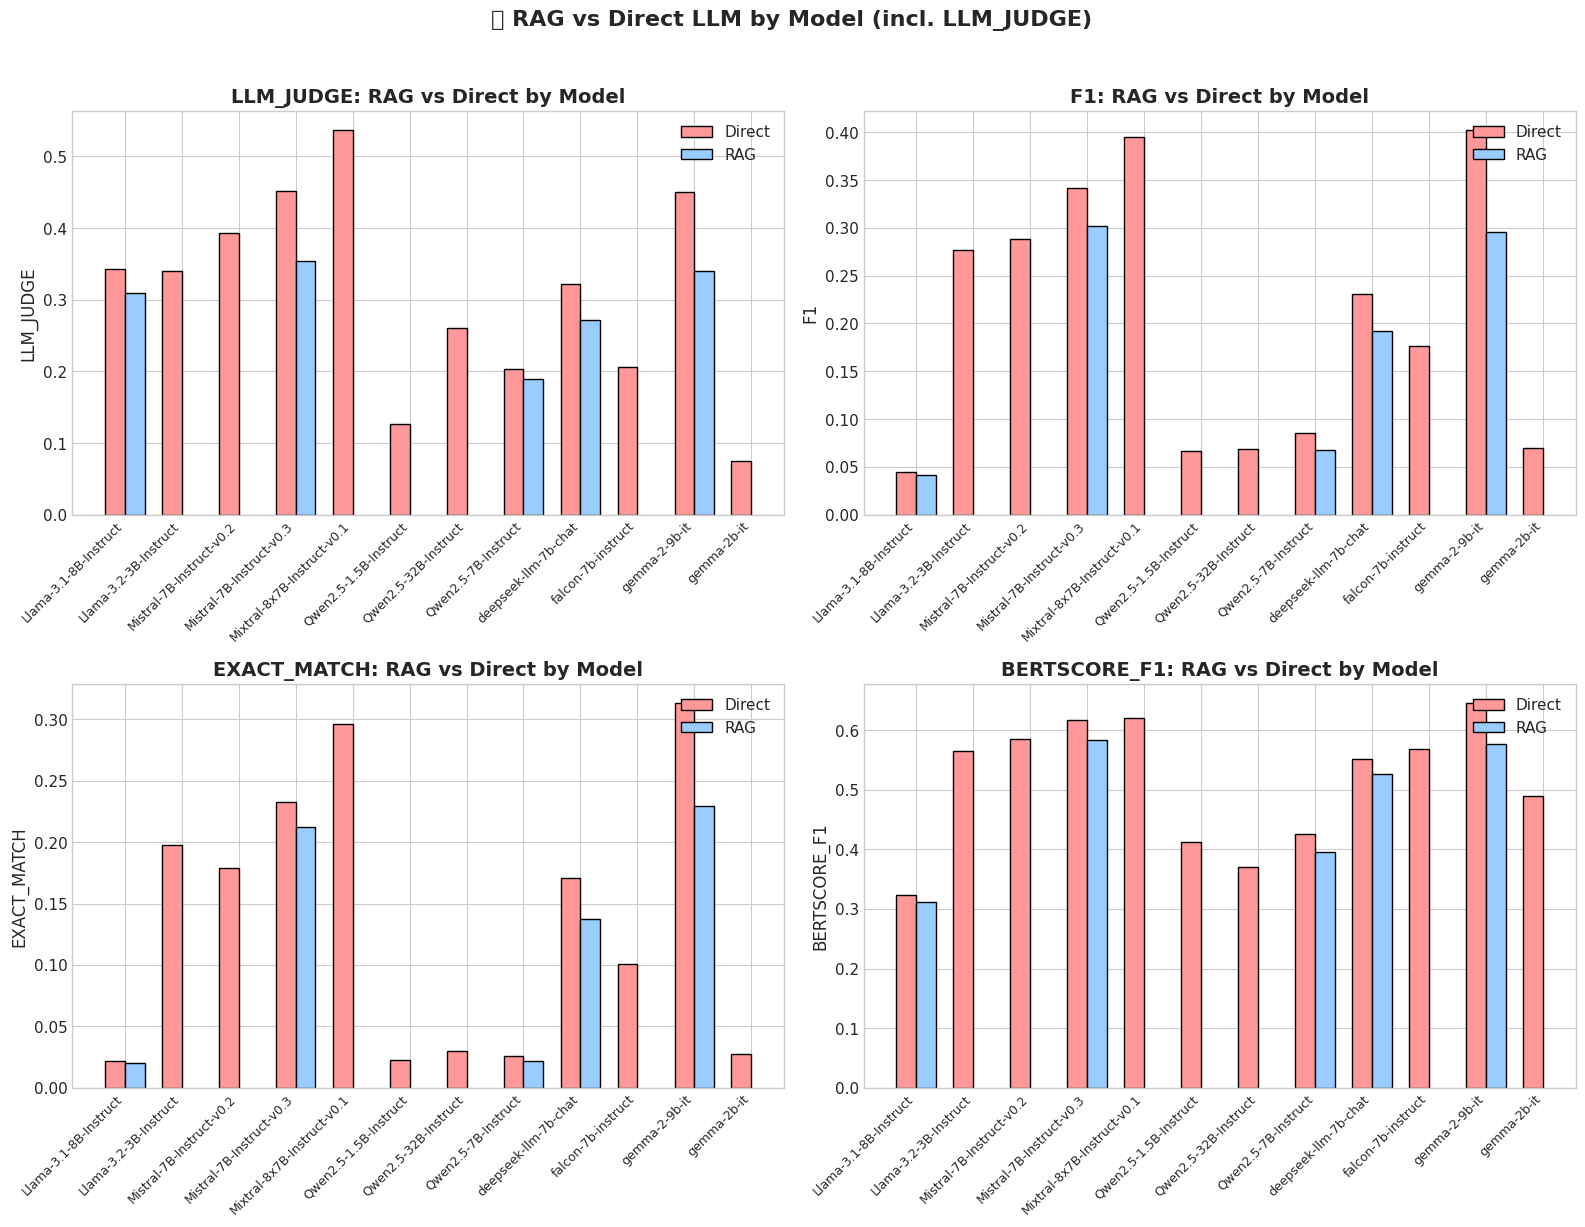

In [57]:
# RAG vs Direct by Model - Include LLM Judge
metrics_for_comparison = ['llm_judge', 'f1', 'exact_match', 'bertscore_f1']  # Focus on llm_judge first

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, metric in enumerate(metrics_for_comparison):
    if metric not in df.columns:
        continue
    
    ax = axes[i // 2, i % 2]
    
    pivot = df.pivot_table(values=metric, index='model_short', columns='type', aggfunc='mean')
    counts = df.groupby(['model_short', 'type']).size().unstack(fill_value=0)
    
    models = pivot.index.tolist()
    x = np.arange(len(models))
    width = 0.35
    
    if 'direct' in pivot.columns:
        ax.bar(x - width/2, pivot['direct'], width, label='Direct', color='#ff9999', edgecolor='black')
    if 'rag' in pivot.columns:
        ax.bar(x + width/2, pivot['rag'], width, label='RAG', color='#99ccff', edgecolor='black')
    
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()}: RAG vs Direct by Model', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax.legend(loc='upper right')

plt.suptitle('🔄 RAG vs Direct LLM by Model (incl. LLM_JUDGE)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

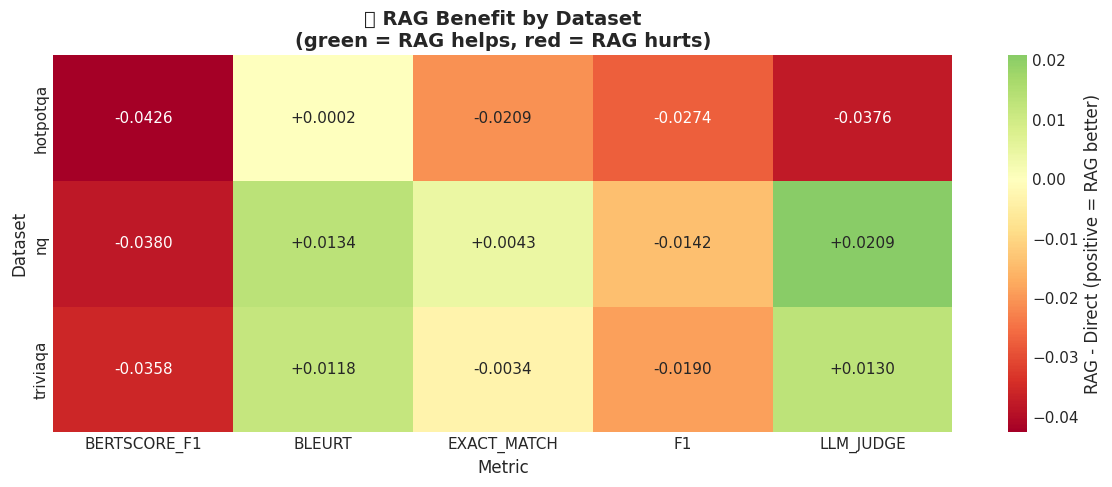


Sample counts per dataset:
  triviaqa: Direct n=42, RAG n=60
  nq: Direct n=42, RAG n=60
  hotpotqa: Direct n=42, RAG n=60


In [58]:
# RAG benefit by dataset - Visual comparison
benefit_data = []
for dataset in df['dataset'].unique():
    df_d = df[(df['dataset'] == dataset) & (df['type'] == 'direct')]
    df_r = df[(df['dataset'] == dataset) & (df['type'] == 'rag')]
    
    for metric in METRICS:
        if metric not in df.columns:
            continue
        direct_mean = df_d[metric].mean()
        rag_mean = df_r[metric].mean()
        diff = rag_mean - direct_mean
        benefit_data.append({
            'dataset': dataset, 'metric': metric.upper(),
            'direct': direct_mean, 'rag': rag_mean, 'diff': diff,
            'n_direct': len(df_d), 'n_rag': len(df_r)
        })

benefit_df = pd.DataFrame(benefit_data)

# Pivot for heatmap
pivot = benefit_df.pivot(index='dataset', columns='metric', values='diff')

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(pivot, annot=True, fmt='+.4f', cmap='RdYlGn', center=0, ax=ax, 
            cbar_kws={'label': 'RAG - Direct (positive = RAG better)'})
ax.set_title('📊 RAG Benefit by Dataset\n(green = RAG helps, red = RAG hurts)', fontsize=14, fontweight='bold')
ax.set_xlabel('Metric')
ax.set_ylabel('Dataset')
plt.tight_layout()
plt.show()

# Sample counts per dataset
print('\nSample counts per dataset:')
for dataset in df['dataset'].unique():
    df_d = df[(df['dataset'] == dataset) & (df['type'] == 'direct')]
    df_r = df[(df['dataset'] == dataset) & (df['type'] == 'rag')]
    print(f'  {dataset}: Direct n={len(df_d)}, RAG n={len(df_r)}')

## 5️⃣ Metric Correlation Analysis

Do different metrics agree on what's a good answer? How do they rank experiments?

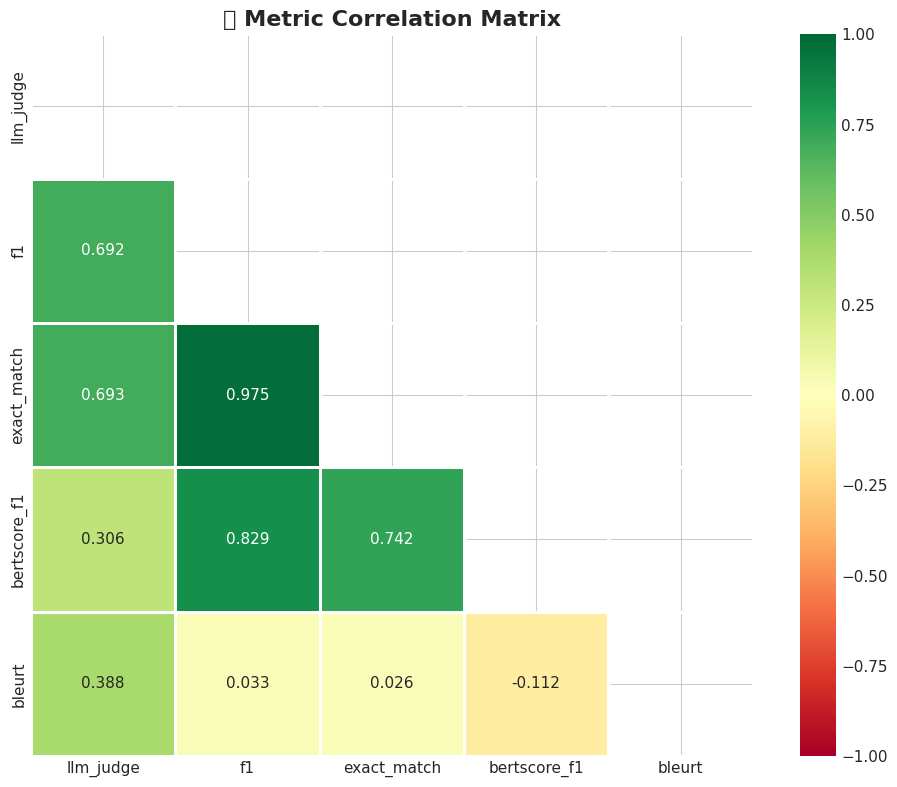


🔍 Key Correlations:
  llm_judge ↔ f1: 0.692 (Moderate)
  llm_judge ↔ exact_match: 0.693 (Moderate)
  llm_judge ↔ bertscore_f1: 0.306 (Weak)
  llm_judge ↔ bleurt: 0.388 (Weak)
  f1 ↔ exact_match: 0.975 (Strong)
  f1 ↔ bertscore_f1: 0.829 (Strong)
  f1 ↔ bleurt: 0.033 (Weak)
  exact_match ↔ bertscore_f1: 0.742 (Strong)
  exact_match ↔ bleurt: 0.026 (Weak)
  bertscore_f1 ↔ bleurt: -0.112 (Weak)


In [59]:
# Metric correlation matrix
metrics_for_corr = [m for m in METRICS if m in df.columns and df[m].notna().sum() > 10]

if len(metrics_for_corr) >= 2:
    correlation = df[metrics_for_corr].corr()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    
    sns.heatmap(correlation, mask=mask, annot=True, fmt='.3f', 
                cmap='RdYlGn', center=0, vmin=-1, vmax=1,
                ax=ax, square=True, linewidths=1)
    
    ax.set_title('📊 Metric Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print('\n🔍 Key Correlations:')
    for i, m1 in enumerate(metrics_for_corr):
        for m2 in metrics_for_corr[i+1:]:
            corr = correlation.loc[m1, m2]
            strength = 'Strong' if abs(corr) > 0.7 else 'Moderate' if abs(corr) > 0.4 else 'Weak'
            print(f'  {m1} ↔ {m2}: {corr:.3f} ({strength})')

In [60]:
# Rank agreement analysis - do metrics rank experiments the same way?
from scipy.stats import spearmanr

print('📊 RANK AGREEMENT: Do Metrics Rank Experiments Similarly?')
print('=' * 70)

print('\nSpearman Rank Correlations:')
for i, m1 in enumerate(metrics_for_corr):
    for m2 in metrics_for_corr[i+1:]:
        valid_mask = df[m1].notna() & df[m2].notna()
        if valid_mask.sum() > 10:
            rho, p = spearmanr(df.loc[valid_mask, m1], df.loc[valid_mask, m2])
            agree = '✅ Agree' if rho > 0.6 else '⚠️ Somewhat' if rho > 0.3 else '❌ Disagree'
            print(f'  {m1:15} vs {m2:15}: ρ={rho:.3f} (p={p:.4f}) {agree}')

📊 RANK AGREEMENT: Do Metrics Rank Experiments Similarly?

Spearman Rank Correlations:
  llm_judge       vs f1             : ρ=0.660 (p=0.0000) ✅ Agree
  llm_judge       vs exact_match    : ρ=0.653 (p=0.0000) ✅ Agree
  llm_judge       vs bertscore_f1   : ρ=0.320 (p=0.0000) ⚠️ Somewhat
  llm_judge       vs bleurt         : ρ=0.388 (p=0.0000) ⚠️ Somewhat
  f1              vs exact_match    : ρ=0.976 (p=0.0000) ✅ Agree
  f1              vs bertscore_f1   : ρ=0.830 (p=0.0000) ✅ Agree
  f1              vs bleurt         : ρ=0.052 (p=0.3651) ❌ Disagree
  exact_match     vs bertscore_f1   : ρ=0.794 (p=0.0000) ✅ Agree
  exact_match     vs bleurt         : ρ=0.065 (p=0.2551) ❌ Disagree
  bertscore_f1    vs bleurt         : ρ=0.081 (p=0.1580) ❌ Disagree


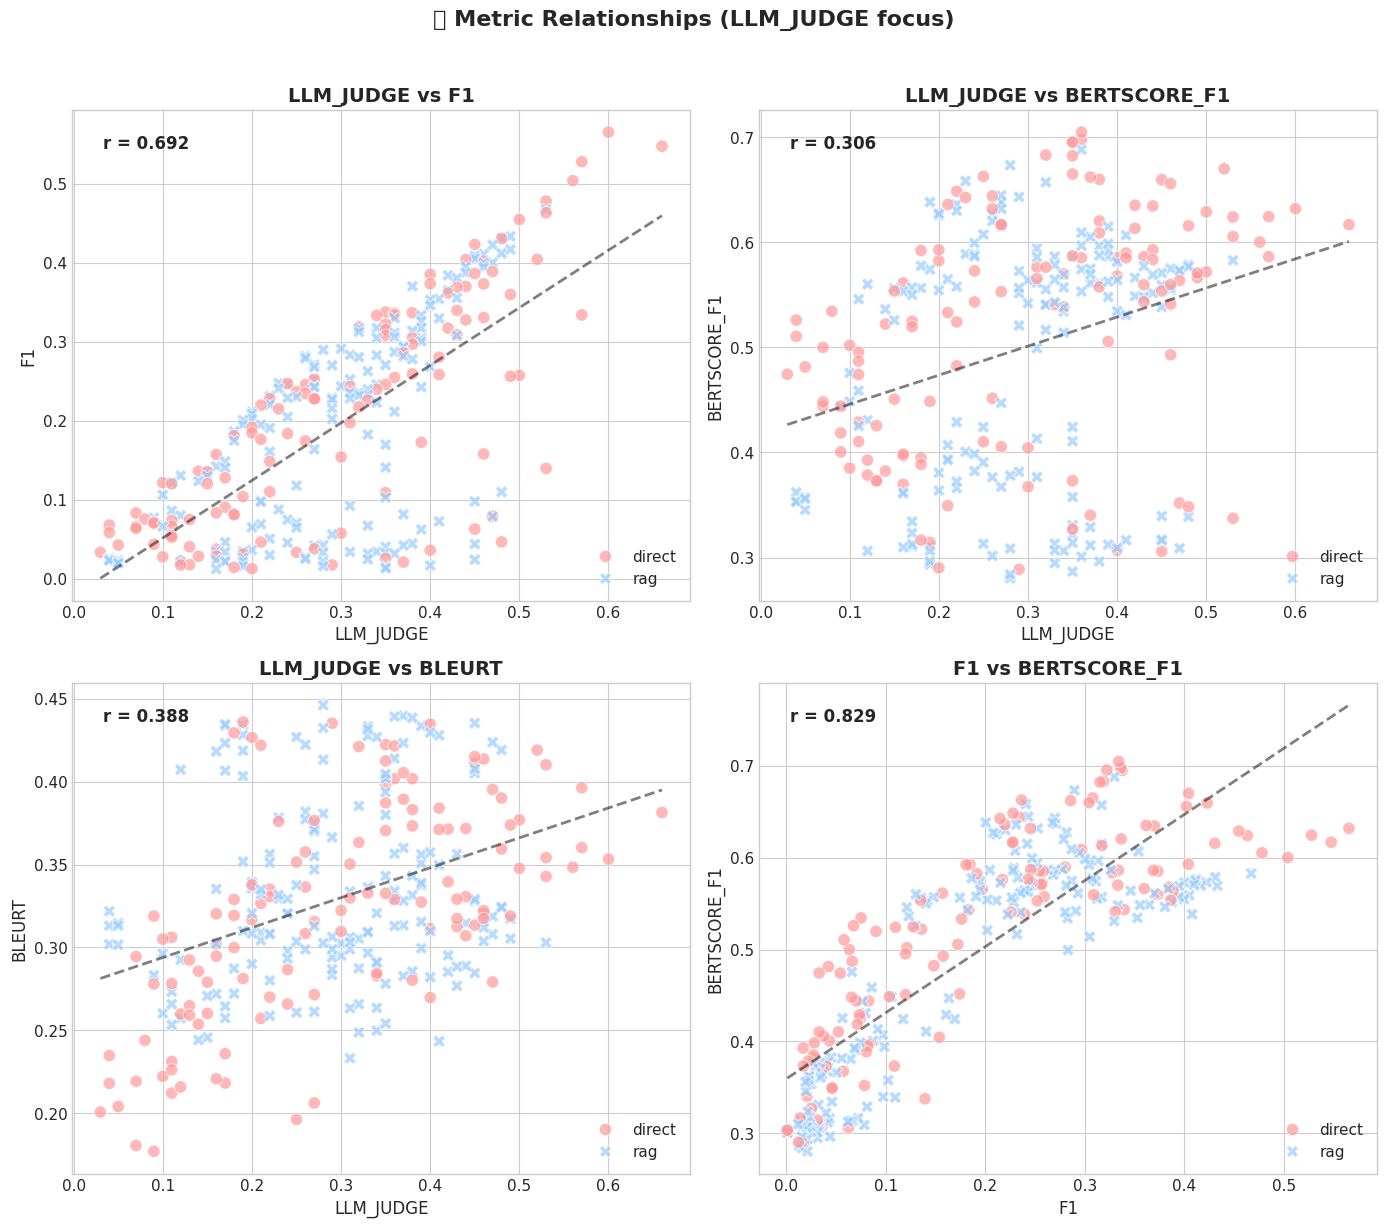

In [61]:
# Scatter plots: metric pairs - Focus on LLM Judge comparisons
metric_pairs = [('llm_judge', 'f1'), ('llm_judge', 'bertscore_f1'), ('llm_judge', 'bleurt'), ('f1', 'bertscore_f1')]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, (m1, m2) in enumerate(metric_pairs):
    ax = axes[i // 2, i % 2]
    if m1 in df.columns and m2 in df.columns:
        valid = df[[m1, m2, 'type']].dropna()
        sns.scatterplot(data=valid, x=m1, y=m2, hue='type', style='type', 
                        alpha=0.7, s=80, ax=ax, palette=['#ff9999', '#99ccff'])
        
        # Add trend line
        if len(valid) > 5:
            z = np.polyfit(valid[m1], valid[m2], 1)
            p_fn = np.poly1d(z)
            x_line = np.linspace(valid[m1].min(), valid[m1].max(), 100)
            ax.plot(x_line, p_fn(x_line), 'k--', alpha=0.5, linewidth=2)
            
            # Add correlation
            rho = valid[m1].corr(valid[m2])
            ax.annotate(f'r = {rho:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                       fontsize=12, fontweight='bold', va='top')
        
        ax.set_xlabel(m1.upper())
        ax.set_ylabel(m2.upper())
        ax.set_title(f'{m1.upper()} vs {m2.upper()}', fontweight='bold')
        ax.legend(loc='lower right')

plt.suptitle('📈 Metric Relationships (LLM_JUDGE focus)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6️⃣ Head-to-Head Model Competition

Compare how different models answer the same questions.

In [62]:
# =============================================================================
# LOAD PREDICTIONS FOR HEAD-TO-HEAD ANALYSIS
# =============================================================================

def load_all_predictions(loader: ResultsLoader, results: list) -> Dict[str, List[Dict]]:
    """Load predictions for all experiments."""
    all_preds = {}
    for r in results:
        preds = loader.load_predictions(r.name)
        if preds:
            all_preds[r.name] = preds
    return all_preds

print('Loading predictions from all experiments...')
all_predictions = load_all_predictions(loader, results)
print(f'✅ Loaded predictions from {len(all_predictions)} experiments')

Loading predictions from all experiments...


✅ Loaded predictions from 306 experiments


In [63]:
def show_head_to_head(question_idx: int = 0, 
                      dataset: str = 'nq',
                      exp_type: str = None,
                      models: List[str] = None,
                      n_models: int = 5):
    """
    Show how different models/configs answered the same question.
    
    Args:
        question_idx: Index of the question in the dataset
        dataset: Dataset to filter by (nq, hotpotqa, triviaqa)
        exp_type: Filter by type (direct, rag, or None for both)
        models: Specific models to compare, or None for top performers
        n_models: Number of models to show if models not specified
    """
    print('=' * 80)
    print(f'🥊 HEAD-TO-HEAD: Question {question_idx} from {dataset.upper()}')
    print('=' * 80)
    
    # Filter experiments
    filtered_results = [r for r in results if r.dataset == dataset]
    if exp_type:
        filtered_results = [r for r in filtered_results if r.type == exp_type]
    
    if models:
        filtered_results = [r for r in filtered_results if r.model_short in models]
    else:
        # Take top N by f1
        filtered_results = sorted(filtered_results, key=lambda r: r.f1, reverse=True)[:n_models]
    
    question = None
    expected = None
    
    comparisons = []
    
    for r in filtered_results:
        if r.name not in all_predictions:
            continue
        
        preds = all_predictions[r.name]
        pred = next((p for p in preds if p.get('idx') == question_idx), None)
        
        if pred:
            if question is None:
                question = pred.get('question', 'N/A')
                expected = pred.get('expected', [])
            
            metrics = pred.get('metrics', {})
            comparisons.append({
                'name': r.name,
                'model': r.model_short,
                'type': r.type,
                'prompt': r.prompt,
                'prediction': pred.get('prediction', 'N/A'),
                'f1': metrics.get('f1', 0),
                'bertscore': metrics.get('bertscore', 0),
                'llm_judge': metrics.get('llm_judge_qa', 0),
                'has_rag': r.type == 'rag',
                'retrieved_docs': pred.get('retrieved_docs', [])
            })
    
    if not comparisons:
        print('No predictions found for this question.')
        return
    
    # Sort by F1
    comparisons = sorted(comparisons, key=lambda x: x['f1'], reverse=True)
    
    # Display
    print(f'\n📝 Question: {question}')
    print(f'✅ Expected: {expected}')
    print()
    print('-' * 80)
    
    for i, c in enumerate(comparisons):
        medal = ['🥇', '🥈', '🥉'][i] if i < 3 else '  '
        rag_tag = '[RAG]' if c['has_rag'] else '[Direct]'
        
        print(f"{medal} {c['model']:20} {rag_tag:8} {c['prompt']:10}")
        print(f"   Answer: {c['prediction'][:100]}{'...' if len(c['prediction']) > 100 else ''}")
        print(f"   F1: {c['f1']:.3f} | BERTScore: {c['bertscore']:.3f} | LLM Judge: {c['llm_judge']:.1f}")
        
        if c['retrieved_docs']:
            print(f"   📚 Top retrieved doc (score={c['retrieved_docs'][0].get('score', 0):.3f}):")
            doc_content = c['retrieved_docs'][0].get('content', '')[:150]
            print(f"      '{doc_content}...'")
        print()
    
    return comparisons

# Example usage
show_head_to_head(question_idx=0, dataset='nq', n_models=6)

🥊 HEAD-TO-HEAD: Question 0 from NQ

📝 Question: when was the last time anyone was on the moon
✅ Expected: ['14 December 1972 UTC', 'December 1972']

--------------------------------------------------------------------------------
🥇 gemma-2-9b-it        [Direct] fewshot   
   Answer: December 1972
   F1: 1.000 | BERTScore: 0.716 | LLM Judge: 1.0

🥈 gemma-2-9b-it        [RAG]    fewshot   
   Answer: December 1972
   F1: 1.000 | BERTScore: 0.716 | LLM Judge: 1.0
   📚 Top retrieved doc (score=0.881):
      'from 22 August 1976 until 14 December 2013. To date, the United States is the only country to have successfully landed humans on the Moon. The last mi...'

🥉 Mistral-7B-Instruct-v0.3 [Direct] fewshot   
   Answer: December 14, 1972
   F1: 0.857 | BERTScore: 0.764 | LLM Judge: 1.0

   gemma-2-9b-it        [Direct] fewshot   
   Answer: December 19, 1972
   F1: 0.800 | BERTScore: 0.743 | LLM Judge: 0.0

   Mistral-7B-Instruct-v0.3 [Direct] fewshot   
   Answer: 1972
   F1: 0.667 | BERTSc

[{'name': 'direct_hf_google_gemma29bit_fewshot_nq_none',
  'model': 'gemma-2-9b-it',
  'type': 'direct',
  'prompt': 'fewshot',
  'prediction': 'December 1972',
  'f1': 1.0,
  'bertscore': 0.7155485153198242,
  'llm_judge': 1.0,
  'has_rag': False,
  'retrieved_docs': []},
 {'name': 'rag_hf_google_gemma29bit_simple_e5_recursive_512_k3_fewshot_nq_none',
  'model': 'gemma-2-9b-it',
  'type': 'rag',
  'prompt': 'fewshot',
  'prediction': 'December 1972',
  'f1': 1.0,
  'bertscore': 0.7155488133430481,
  'llm_judge': 1.0,
  'has_rag': True,
  'retrieved_docs': [{'rank': 1,
    'content': 'from 22 August 1976 until 14 December 2013. To date, the United States is the only country to have successfully landed humans on the Moon. The last mission was in December, 1972, and the last human to walk on the Moon was Gene Cernan.\n\nReferences\n\nMoon\nAstronomy',
    'score': 0.8809345960617065},
   {'rank': 2,
    'content': "Twelve people have walked on Earth's Moon. The first one was Neil Armstro

In [64]:
# RAG vs Direct on same question - side by side
def compare_rag_vs_direct(question_idx: int, model: str, dataset: str = 'nq'):
    """Compare RAG and Direct answers from the same model on the same question."""
    print(f'🔄 RAG vs DIRECT: {model} on Question {question_idx}')
    print('=' * 80)
    
    # Find matching experiments
    direct_exp = [r for r in results if r.model_short == model and r.type == 'direct' and r.dataset == dataset]
    rag_exp = [r for r in results if r.model_short == model and r.type == 'rag' and r.dataset == dataset]
    
    if not direct_exp:
        print(f'No direct experiments found for {model} on {dataset}')
        return
    if not rag_exp:
        print(f'No RAG experiments found for {model} on {dataset}')
        return
    
    for exp in [direct_exp[0]] + rag_exp[:2]:  # Compare 1 direct + 2 RAG configs
        if exp.name not in all_predictions:
            continue
        
        preds = all_predictions[exp.name]
        pred = next((p for p in preds if p.get('idx') == question_idx), None)
        
        if not pred:
            continue
        
        print(f"\n{'📚 RAG' if exp.type == 'rag' else '🧠 DIRECT'}: {exp.name[:50]}")
        print(f"Question: {pred.get('question', 'N/A')}")
        print(f"Expected: {pred.get('expected', [])}")
        print(f"Answer: {pred.get('prediction', 'N/A')}")
        
        metrics = pred.get('metrics', {})
        print(f"F1: {metrics.get('f1', 0):.3f} | BERTScore: {metrics.get('bertscore', 0):.3f}")
        
        if pred.get('retrieved_docs'):
            print(f"\nRetrieved ({len(pred['retrieved_docs'])} docs):")
            for doc in pred['retrieved_docs'][:2]:
                print(f"  [{doc['rank']}] (score={doc.get('score', 0):.3f}) {doc['content'][:100]}...")

# Example
models_available = df['model_short'].unique()
if len(models_available) > 0:
    compare_rag_vs_direct(question_idx=0, model=models_available[0], dataset='nq')

🔄 RAG vs DIRECT: gemma-2-9b-it on Question 0

🧠 DIRECT: direct_hf_google_gemma29bit_fewshot_nq_none
Question: when was the last time anyone was on the moon
Expected: ['14 December 1972 UTC', 'December 1972']
Answer: December 1972
F1: 1.000 | BERTScore: 0.716

📚 RAG: rag_hf_google_gemma29bit_simple_e5_recursive_512_k
Question: when was the last time anyone was on the moon
Expected: ['14 December 1972 UTC', 'December 1972']
Answer: December 1972
F1: 1.000 | BERTScore: 0.716

Retrieved (3 docs):
  [1] (score=0.881) from 22 August 1976 until 14 December 2013. To date, the United States is the only country to have s...
  [2] (score=0.874) Twelve people have walked on Earth's Moon. The first one was Neil Armstrong and the last one was Har...

📚 RAG: rag_hf_google_gemma29bit_simple_minilm_recursive_1
Question: when was the last time anyone was on the moon
Expected: ['14 December 1972 UTC', 'December 1972']
Answer: December 1972
F1: 1.000 | BERTScore: 0.716

Retrieved (3 docs):
  [1] (score=0.

## 7️⃣ Error Pattern Analysis

When do models fail? What types of questions are hardest?

In [65]:
def analyze_errors():
    """Find patterns in model failures."""
    
    # Collect per-question performance across all experiments
    question_perf = defaultdict(lambda: {'scores': [], 'experiments': [], 'question': '', 'expected': []})
    
    for exp_name, preds in all_predictions.items():
        for pred in preds:
            idx = pred.get('idx', -1)
            question = pred.get('question', '')
            expected = pred.get('expected', [])
            f1 = pred.get('metrics', {}).get('f1', 0)
            
            key = f"{question[:50]}_{idx}"
            question_perf[key]['scores'].append(f1)
            question_perf[key]['experiments'].append(exp_name)
            question_perf[key]['question'] = question
            question_perf[key]['expected'] = expected
    
    # Calculate difficulty (avg F1 across all experiments)
    difficulties = []
    for key, data in question_perf.items():
        if len(data['scores']) >= 5:  # Only questions with enough data
            difficulties.append({
                'key': key,
                'question': data['question'],
                'expected': data['expected'],
                'avg_f1': np.mean(data['scores']),
                'std_f1': np.std(data['scores']),
                'max_f1': max(data['scores']),
                'n_experiments': len(data['scores']),
            })
    
    diff_df = pd.DataFrame(difficulties)
    
    if len(diff_df) == 0:
        print('Not enough data for error analysis')
        return None
    
    print('🔍 QUESTION DIFFICULTY ANALYSIS')
    print('=' * 80)
    
    # Distribution of difficulty
    print(f'\nAnalyzed {len(diff_df)} questions')
    print(f'Average F1 across all questions: {diff_df["avg_f1"].mean():.3f}')
    
    # Hardest questions (everyone fails)
    print('\n❌ HARDEST QUESTIONS (lowest avg F1):')
    hardest = diff_df.nsmallest(5, 'avg_f1')
    for _, row in hardest.iterrows():
        print(f'  F1={row["avg_f1"]:.3f} (max={row["max_f1"]:.3f})')
        print(f'  Q: {row["question"][:80]}...')
        print(f'  Expected: {row["expected"]}')
        print()
    
    # Easiest questions (everyone succeeds)
    print('\n✅ EASIEST QUESTIONS (highest avg F1):')
    easiest = diff_df.nlargest(5, 'avg_f1')
    for _, row in easiest.iterrows():
        print(f'  F1={row["avg_f1"]:.3f}')
        print(f'  Q: {row["question"][:80]}...')
        print(f'  Expected: {row["expected"]}')
        print()
    
    # Most variable questions (some succeed, some fail)
    print('\n🎲 MOST VARIABLE QUESTIONS (high std dev):')
    variable = diff_df.nlargest(5, 'std_f1')
    for _, row in variable.iterrows():
        print(f'  F1={row["avg_f1"]:.3f} ± {row["std_f1"]:.3f}')
        print(f'  Q: {row["question"][:80]}...')
        print()
    
    return diff_df

difficulty_df = analyze_errors()

🔍 QUESTION DIFFICULTY ANALYSIS

Analyzed 300 questions
Average F1 across all questions: 0.188

❌ HARDEST QUESTIONS (lowest avg F1):
  F1=0.000 (max=0.000)
  Q: What is the only novel to top the best-seller lists for two consecutive years?...
  Expected: ['Jonathan livingstone seagull', 'Jonathan Livingston Seagull (movie)', 'Jonathon Livingston Seagull', 'Jonathon Livingston Seagulll', 'Johnathan Livingston Seagull', 'Johnathon Livingston Seagull', 'Livingston Seagull', 'Jonathan Livingston Seagull', 'Jonathan Livingstone Seagull']

  F1=0.000 (max=0.000)
  Q: Which musician founded the Red Hot Peppers?...
  Expected: ['Ferdinand Lamothe', 'Ferdinand Joseph Morton', 'Jelly-Roll Morton', 'Ferdinand Joseph Lamothe', 'F.P. Lamothe', 'Jelly Roll Morton', 'Joseph Ferdinand Morton', 'Ferdinand Morton', 'Ferdinand Joseph La Menthe', 'Louise Monette', 'Jellyroll Morton', 'Ferdinand %22Jelly Roll%22 Morton']

  F1=0.000 (max=0.000)
  Q: Which founder of the company Triad was accused by the USA 

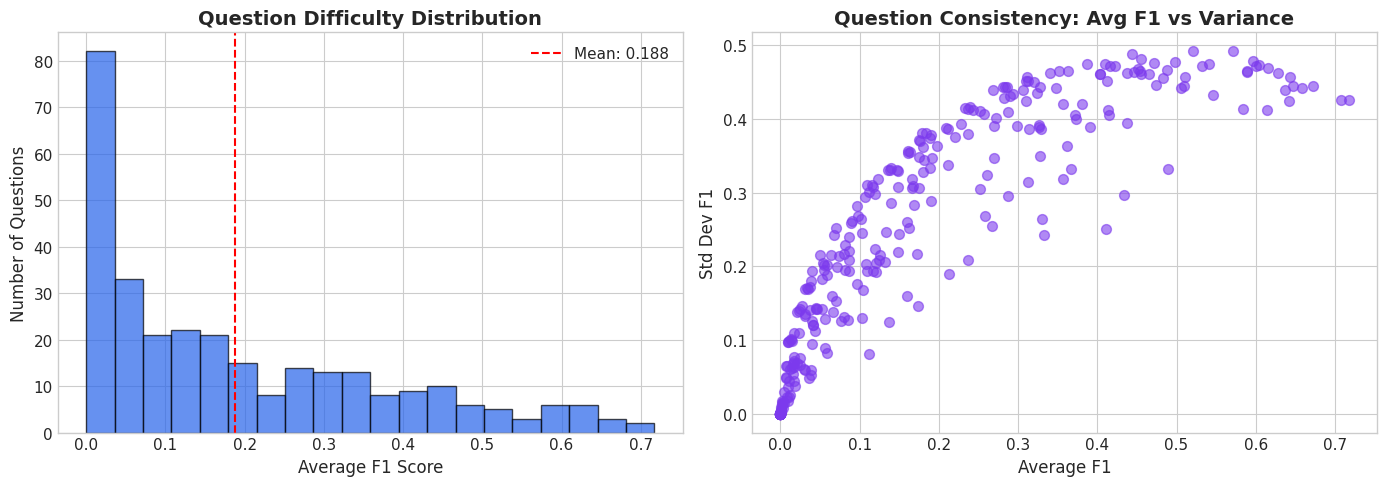

In [66]:
# Difficulty distribution
if difficulty_df is not None and len(difficulty_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of average F1
    axes[0].hist(difficulty_df['avg_f1'], bins=20, edgecolor='black', alpha=0.7, color=COLORS['primary'])
    axes[0].axvline(difficulty_df['avg_f1'].mean(), color='red', linestyle='--', label=f'Mean: {difficulty_df["avg_f1"].mean():.3f}')
    axes[0].set_xlabel('Average F1 Score')
    axes[0].set_ylabel('Number of Questions')
    axes[0].set_title('Question Difficulty Distribution', fontweight='bold')
    axes[0].legend()
    
    # Scatter: avg F1 vs std F1
    axes[1].scatter(difficulty_df['avg_f1'], difficulty_df['std_f1'], alpha=0.6, s=50, c=COLORS['secondary'])
    axes[1].set_xlabel('Average F1')
    axes[1].set_ylabel('Std Dev F1')
    axes[1].set_title('Question Consistency: Avg F1 vs Variance', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [67]:
def find_interesting_examples(criteria: str = 'controversial'):
    """
    Find interesting examples based on different criteria.
    
    Args:
        criteria: One of:
            - 'controversial': Questions where models disagree
            - 'rag_helps': Questions where RAG significantly improves F1
            - 'rag_hurts': Questions where RAG significantly hurts F1
            - 'perfect': Questions all models get right
    """
    print(f'🔍 Finding interesting examples: {criteria}')
    print('=' * 80)
    
    # Group predictions by question
    by_question = defaultdict(list)
    
    for exp_name, preds in all_predictions.items():
        exp = next((r for r in results if r.name == exp_name), None)
        if not exp:
            continue
        
        for pred in preds:
            q = pred.get('question', '')
            by_question[q].append({
                'exp': exp,
                'pred': pred,
                'f1': pred.get('metrics', {}).get('f1', 0),
            })
    
    found = []
    
    for question, data in by_question.items():
        if len(data) < 5:
            continue
        
        f1_scores = [d['f1'] for d in data]
        
        if criteria == 'controversial':
            # High variance in scores
            if np.std(f1_scores) > 0.3:
                found.append((question, data, np.std(f1_scores)))
        
        elif criteria == 'rag_helps':
            direct_scores = [d['f1'] for d in data if d['exp'].type == 'direct']
            rag_scores = [d['f1'] for d in data if d['exp'].type == 'rag']
            if direct_scores and rag_scores:
                improvement = np.mean(rag_scores) - np.mean(direct_scores)
                if improvement > 0.2:
                    found.append((question, data, improvement))
        
        elif criteria == 'rag_hurts':
            direct_scores = [d['f1'] for d in data if d['exp'].type == 'direct']
            rag_scores = [d['f1'] for d in data if d['exp'].type == 'rag']
            if direct_scores and rag_scores:
                decline = np.mean(direct_scores) - np.mean(rag_scores)
                if decline > 0.2:
                    found.append((question, data, decline))
        
        elif criteria == 'perfect':
            if min(f1_scores) > 0.9:
                found.append((question, data, np.mean(f1_scores)))
    
    # Sort and display
    found = sorted(found, key=lambda x: x[2], reverse=True)[:5]
    
    for question, data, score in found:
        print(f'\nQ: {question[:80]}...')
        print(f'Expected: {data[0]["pred"].get("expected", [])}')
        print(f'Score metric: {score:.3f}')
        print('\nAnswers:')
        
        for d in sorted(data, key=lambda x: x['f1'], reverse=True)[:5]:
            rag_tag = '[RAG]' if d['exp'].type == 'rag' else '[Dir]'
            print(f"  {rag_tag} {d['exp'].model_short:15} F1={d['f1']:.3f}: {d['pred'].get('prediction', '')[:60]}")
        print('-' * 70)

# Example usage
find_interesting_examples('controversial')

🔍 Finding interesting examples: controversial

Q: Are Giuseppe Verdi and Ambroise Thomas both Opera composers ?...
Expected: ['yes']
Score metric: 0.492

Answers:
  [Dir] Mistral-7B-Instruct-v0.3 F1=1.000: Yes
  [Dir] gemma-2-9b-it   F1=1.000: yes
  [Dir] Mistral-7B-Instruct-v0.3 F1=1.000: Yes
  [RAG] gemma-2-9b-it   F1=1.000: Yes
  [Dir] gemma-2-9b-it   F1=1.000: Yes
----------------------------------------------------------------------

Q: What is the name of the singer who's song was released as the lead single from t...
Expected: ['Usher']
Score metric: 0.491

Answers:
  [Dir] Mistral-7B-Instruct-v0.3 F1=1.000: Usher
  [Dir] gemma-2-9b-it   F1=1.000: Usher
  [Dir] Mistral-7B-Instruct-v0.3 F1=1.000: Usher
  [RAG] gemma-2-9b-it   F1=1.000: Usher
  [Dir] gemma-2-9b-it   F1=1.000: Usher
----------------------------------------------------------------------

Q: Are both Dictyosperma, and Huernia described as a genus?...
Expected: ['yes']
Score metric: 0.487

Answers:
  [Dir] Mistral-7B-

In [68]:
# Find examples where RAG helps
find_interesting_examples('rag_helps')

🔍 Finding interesting examples: rag_helps

Q: What is Mel Gibson's middle name?...
Expected: ['Columbkille', 'Colum Cille mac Fedelmtheo', 'Columba, Saint', 'Colmkill', 'St Columcille', 'Colm Cille', 'Colmcille', 'St Columba', 'St Colum Cille', 'St. Columba', 'Saint Columbkille', 'Saint Columba', 'Vita Sancti Columbae', 'Colum Cille', 'Columcille', 'Columbcille', 'Columb Cille', 'St Colm', 'Saint Colm Cille', 'St. Columcille', 'Colmekill', 'Columba of Iona', 'Saint Columb', 'St Colmcille', 'Saint Colmcille', 'Saint Columcille', 'Columba', 'Life of St. Columba', 'Calum Cille', 'Life of Columba', 'Collumcille', 'Vita Columbae', 'Scoto-Hibernian Monasteries']
Score metric: 0.587

Answers:
  [RAG] gemma-2-9b-it   F1=1.000: Colmcille
  [RAG] gemma-2-9b-it   F1=1.000: Colmcille
  [RAG] Mistral-7B-Instruct-v0.3 F1=1.000: Colmcille
  [RAG] gemma-2-9b-it   F1=1.000: Colm-Cille
  [RAG] gemma-2-9b-it   F1=1.000: Colmcille
----------------------------------------------------------------------

Q: 

In [69]:
# Find examples where RAG hurts
find_interesting_examples('rag_hurts')

🔍 Finding interesting examples: rag_hurts

Q: Which journalist first told the world about the My Lai massacre?...
Expected: ['Seymour M. Hersh', 'Sy Hersh', 'Hersh, Seymour M.', 'Seymour Hirsch', 'Seymour (Sy) Myron Hersh', 'Seymour Hersh', 'Chain of Command (book)', 'Seymour Hersch', 'The Dark Side of Camelot', 'Chain of Command: The Road from 9/11 to Abu Ghraib']
Score metric: 0.465

Answers:
  [Dir] gemma-2-9b-it   F1=1.000: Seymour Hersh
  [Dir] Mixtral-8x7B-Instruct-v0.1 F1=1.000: Seymour Hersh
  [Dir] gemma-2-9b-it   F1=1.000: Seymour Hersh
  [Dir] gemma-2-9b-it   F1=1.000: Seymour Hersh
  [Dir] gemma-2-9b-it   F1=1.000: Seymour Hersh
----------------------------------------------------------------------

Q: Tysons Galleria is located in what county?...
Expected: ['Fairfax County']
Score metric: 0.438

Answers:
  [Dir] Mistral-7B-Instruct-v0.3 F1=1.000: Fairfax County
  [Dir] Mixtral-8x7B-Instruct-v0.1 F1=1.000: Fairfax County
  [Dir] deepseek-llm-7b-chat F1=1.000: Fairfax County

## 8️⃣ RAG Configuration Deep Dive

How do different retrieval settings affect performance?

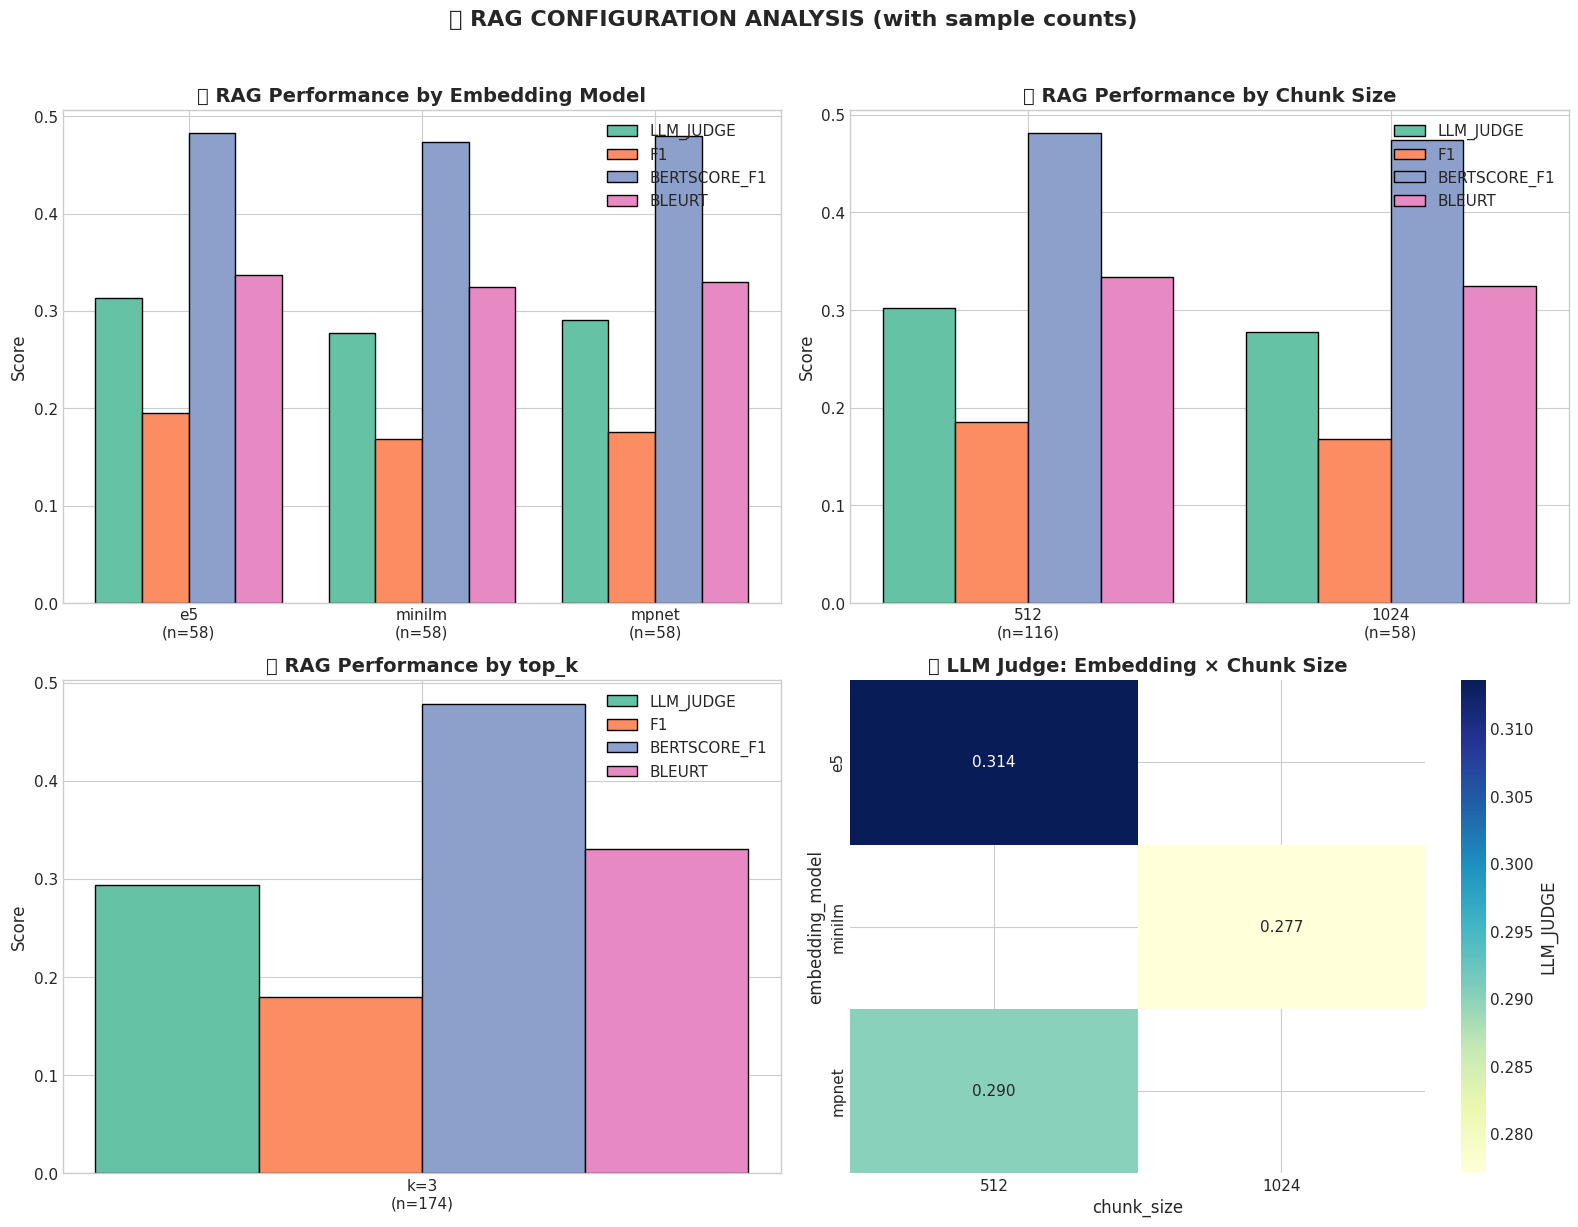


📊 RAG Configuration Summary:

By embedding_model:


llm_judge            f1       bertscore_f1        bleurt      
                     mean count    mean count         mean count    mean count
embedding_model                                                               
e5                 0.3136    58  0.1956    60       0.4824    60  0.3370    60
minilm             0.2771    58  0.1680    60       0.4737    60  0.3248    60
mpnet              0.2902    58  0.1758    60       0.4796    60  0.3300    60


By chunk_size:


llm_judge            f1       bertscore_f1        bleurt      
                mean count    mean count         mean count    mean count
chunk_size                                                               
512           0.3019   116  0.1857   120       0.4810   120  0.3335   120
1024          0.2771    58  0.1680    60       0.4737    60  0.3248    60


By top_k:


llm_judge            f1       bertscore_f1        bleurt      
           mean count    mean count         mean count    mean count
top_k                                                               
3        0.2936   174  0.1798   180       0.4786   180  0.3306   180

In [70]:
# =============================================================================
# RAG CONFIGURATION ANALYSIS - Visual with all metrics incl. LLM Judge
# =============================================================================

if len(df_rag) > 0:
    # Build config comparison data
    config_metrics = ['llm_judge', 'f1', 'bertscore_f1', 'bleurt']  # Focus on LLM Judge
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. By Embedding Model (all metrics)
    ax = axes[0, 0]
    emb_data = df_rag.groupby('embedding_model')[config_metrics].agg(['mean', 'count']).fillna(0)
    emb_means = emb_data.xs('mean', axis=1, level=1)
    emb_counts = emb_data.xs('count', axis=1, level=1).iloc[:, 0]  # First metric's count
    
    x = np.arange(len(emb_means))
    width = 0.2
    for i, metric in enumerate(config_metrics):
        if metric in emb_means.columns:
            ax.bar(x + i * width, emb_means[metric], width, label=metric.upper(), 
                   color=METRIC_PALETTE[i], edgecolor='black')
    ax.set_xticks(x + width * (len(config_metrics) - 1) / 2)
    ax.set_xticklabels([f'{e}\n(n={int(emb_counts[e])})' for e in emb_means.index])
    ax.set_ylabel('Score')
    ax.set_title('📊 RAG Performance by Embedding Model', fontweight='bold')
    ax.legend(loc='upper right')
    
    # 2. By Chunk Size (all metrics)
    ax = axes[0, 1]
    chunk_data = df_rag.groupby('chunk_size')[config_metrics].agg(['mean', 'count']).fillna(0)
    chunk_means = chunk_data.xs('mean', axis=1, level=1)
    chunk_counts = chunk_data.xs('count', axis=1, level=1).iloc[:, 0]
    
    x = np.arange(len(chunk_means))
    for i, metric in enumerate(config_metrics):
        if metric in chunk_means.columns:
            ax.bar(x + i * width, chunk_means[metric], width, label=metric.upper(),
                   color=METRIC_PALETTE[i], edgecolor='black')
    ax.set_xticks(x + width * (len(config_metrics) - 1) / 2)
    ax.set_xticklabels([f'{c}\n(n={int(chunk_counts[c])})' for c in chunk_means.index])
    ax.set_ylabel('Score')
    ax.set_title('📊 RAG Performance by Chunk Size', fontweight='bold')
    ax.legend(loc='upper right')
    
    # 3. By top_k (all metrics)
    ax = axes[1, 0]
    topk_data = df_rag.groupby('top_k')[config_metrics].agg(['mean', 'count']).fillna(0)
    topk_means = topk_data.xs('mean', axis=1, level=1)
    topk_counts = topk_data.xs('count', axis=1, level=1).iloc[:, 0]
    
    x = np.arange(len(topk_means))
    for i, metric in enumerate(config_metrics):
        if metric in topk_means.columns:
            ax.bar(x + i * width, topk_means[metric], width, label=metric.upper(),
                   color=METRIC_PALETTE[i], edgecolor='black')
    ax.set_xticks(x + width * (len(config_metrics) - 1) / 2)
    ax.set_xticklabels([f'k={k}\n(n={int(topk_counts[k])})' for k in topk_means.index])
    ax.set_ylabel('Score')
    ax.set_title('📊 RAG Performance by top_k', fontweight='bold')
    ax.legend(loc='upper right')
    
    # 4. LLM Judge heatmap: Embedding × Chunk Size
    ax = axes[1, 1]
    if 'llm_judge' in df_rag.columns:
        pivot = df_rag.pivot_table(values='llm_judge', index='embedding_model', columns='chunk_size', aggfunc='mean')
        counts = df_rag.groupby(['embedding_model', 'chunk_size']).size().unstack(fill_value=0)
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, cbar_kws={'label': 'LLM_JUDGE'})
        ax.set_title('🎯 LLM Judge: Embedding × Chunk Size', fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No LLM Judge data', ha='center', va='center')
        ax.set_axis_off()
    
    plt.suptitle('📚 RAG CONFIGURATION ANALYSIS (with sample counts)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print('\n📊 RAG Configuration Summary:')
    for dim in ['embedding_model', 'chunk_size', 'top_k']:
        print(f'\nBy {dim}:')
        summary = df_rag.groupby(dim)[config_metrics].agg(['mean', 'count']).round(4)
        display(summary)

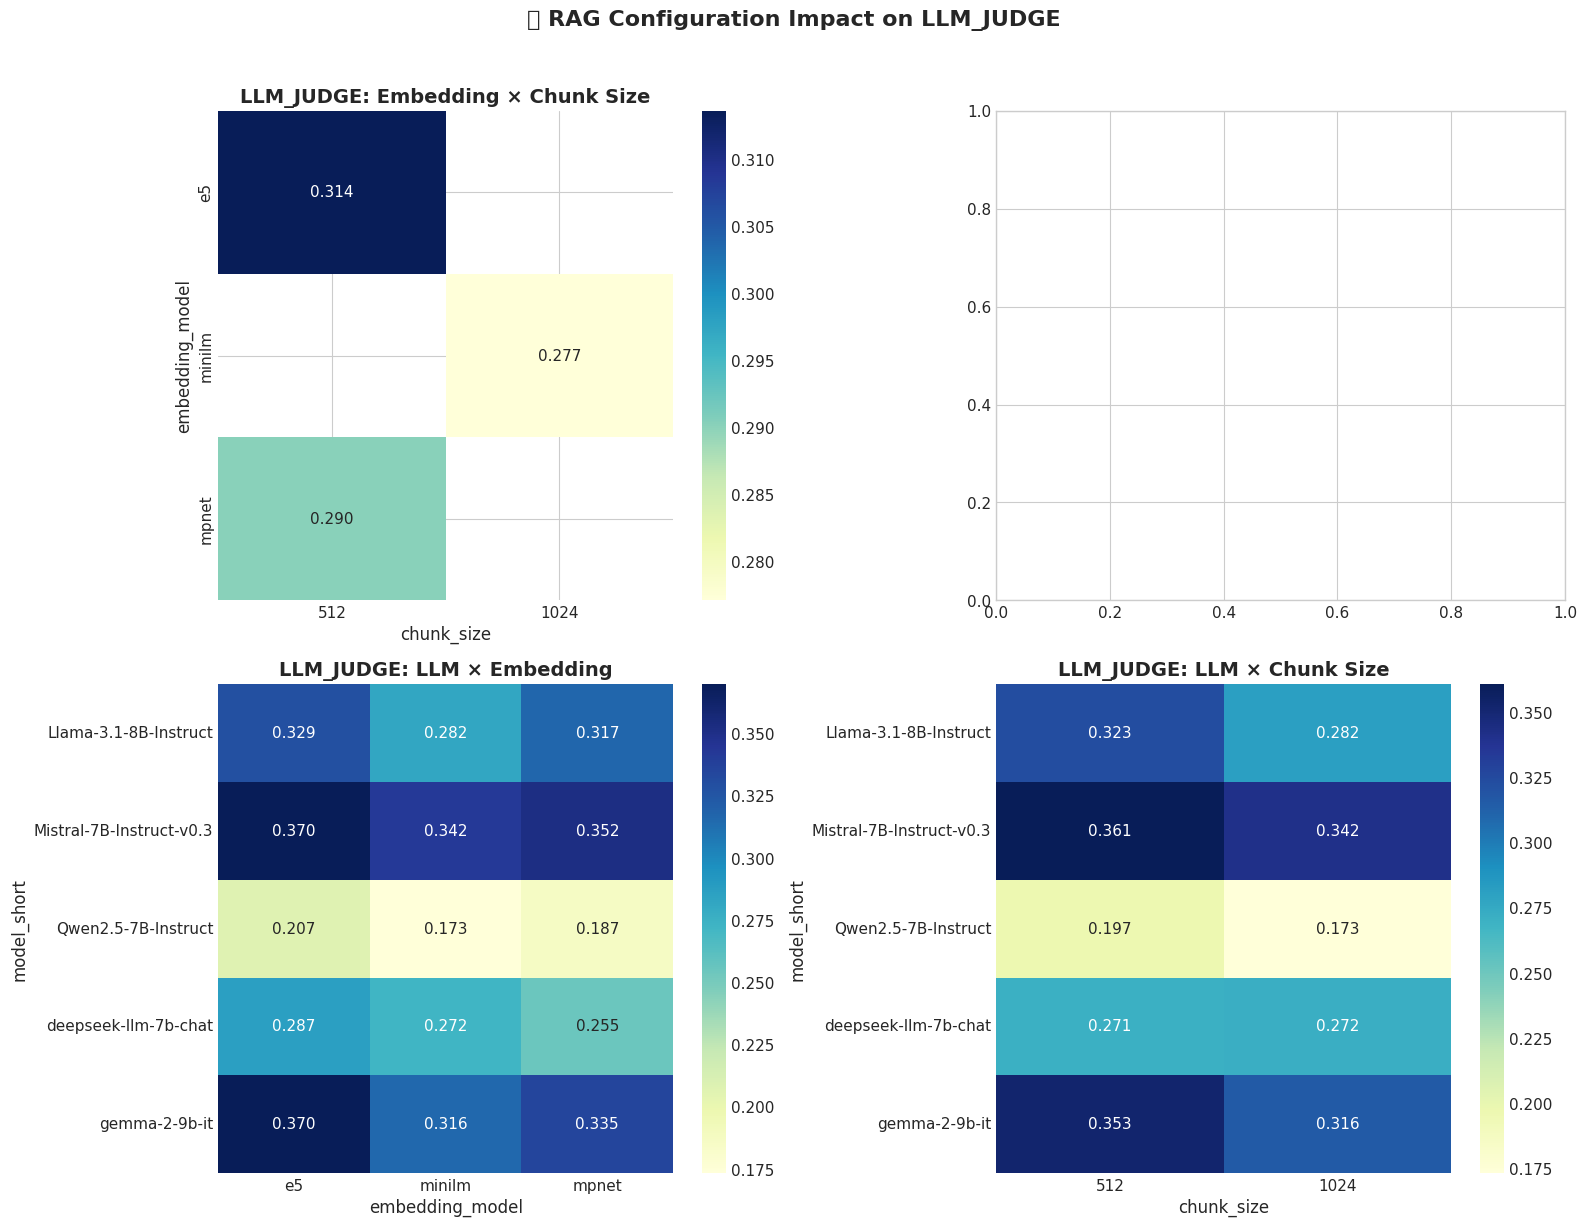

In [71]:
# RAG configuration heatmaps - LLM Judge focus
if len(df_rag) > 0:
    metric = 'llm_judge' if 'llm_judge' in df_rag.columns else 'f1'
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Embedding × Chunk Size - LLM Judge
    if df_rag['embedding_model'].nunique() > 1 and df_rag['chunk_size'].nunique() > 1:
        pivot = df_rag.pivot_table(values=metric, index='embedding_model', columns='chunk_size', aggfunc='mean')
        counts = df_rag.groupby(['embedding_model', 'chunk_size']).size().unstack(fill_value=0)
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[0, 0])
        axes[0, 0].set_title(f'{metric.upper()}: Embedding × Chunk Size', fontweight='bold')
    
    # Embedding × top_k - LLM Judge
    if df_rag['embedding_model'].nunique() > 1 and df_rag['top_k'].nunique() > 1:
        pivot = df_rag.pivot_table(values=metric, index='embedding_model', columns='top_k', aggfunc='mean')
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[0, 1])
        axes[0, 1].set_title(f'{metric.upper()}: Embedding × top_k', fontweight='bold')
    
    # Model × Embedding - LLM Judge
    if df_rag['model_short'].nunique() > 1 and df_rag['embedding_model'].nunique() > 1:
        pivot = df_rag.pivot_table(values=metric, index='model_short', columns='embedding_model', aggfunc='mean')
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[1, 0])
        axes[1, 0].set_title(f'{metric.upper()}: LLM × Embedding', fontweight='bold')
    
    # Model × Chunk Size - LLM Judge
    if df_rag['model_short'].nunique() > 1 and df_rag['chunk_size'].nunique() > 1:
        pivot = df_rag.pivot_table(values=metric, index='model_short', columns='chunk_size', aggfunc='mean')
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[1, 1])
        axes[1, 1].set_title(f'{metric.upper()}: LLM × Chunk Size', fontweight='bold')
    
    plt.suptitle(f'📚 RAG Configuration Impact on {metric.upper()}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

## 9️⃣ Example Browser

Interactive functions to explore specific predictions.

In [72]:
def browse_experiment(exp_name: str, n_examples: int = 5, show_prompt: bool = False):
    """
    Browse predictions from a specific experiment.
    
    Args:
        exp_name: Full or partial experiment name
        n_examples: Number of examples to show
        show_prompt: Whether to show the full prompt
    """
    # Find matching experiment
    matching = [r for r in results if exp_name.lower() in r.name.lower()]
    if not matching:
        print(f'No experiments matching "{exp_name}"')
        print(f'Available: {[r.name for r in results[:10]]}...')
        return
    
    exp = matching[0]
    print(f'📋 EXPERIMENT: {exp.name}')
    print('=' * 80)
    print(f'Model: {exp.model_short}')
    print(f'Type: {exp.type}')
    print(f'Dataset: {exp.dataset}')
    print(f'Prompt: {exp.prompt}')
    print(f'\nMetrics: F1={exp.f1:.4f}, EM={exp.exact_match:.4f}, BERTScore={exp.bertscore_f1:.4f}')
    print()
    
    if exp.name not in all_predictions:
        print('Predictions not loaded')
        return
    
    preds = all_predictions[exp.name]
    
    # Show mix of correct and incorrect
    sorted_preds = sorted(preds, key=lambda p: p.get('metrics', {}).get('f1', 0), reverse=True)
    
    # Top performers
    print('\n✅ TOP PREDICTIONS (highest F1):')
    for pred in sorted_preds[:n_examples]:
        _print_prediction(pred, show_prompt)
    
    # Bottom performers
    print('\n❌ FAILED PREDICTIONS (lowest F1):')
    for pred in sorted_preds[-n_examples:]:
        _print_prediction(pred, show_prompt)


def _print_prediction(pred: dict, show_prompt: bool = False):
    """Helper to print a single prediction."""
    metrics = pred.get('metrics', {})
    print(f'\n  [idx={pred.get("idx")}] F1={metrics.get("f1", 0):.3f}')
    print(f'  Q: {pred.get("question", "N/A")}')
    print(f'  Expected: {pred.get("expected", [])}')
    print(f'  Answer: {pred.get("prediction", "N/A")[:200]}')
    
    if show_prompt:
        print(f'  \nPrompt:\n{pred.get("prompt", "N/A")[:500]}...')
    
    if pred.get('retrieved_docs'):
        print(f'  Retrieved: {len(pred["retrieved_docs"])} docs')
    
    print('-' * 60)

In [73]:
# List available experiments
print('Available experiments (first 20):')
for i, r in enumerate(results[:20]):
    print(f'  {i:2}. {r.name[:60]}... (F1={r.f1:.3f})')

Available experiments (first 20):
   0. direct_hf_google_gemma29bit_fewshot_triviaqa_none... (F1=0.565)
   1. direct_hf_mistralai_Mixtral8x7BInstructv0.1_concise_triviaqa... (F1=0.547)
   2. direct_hf_google_gemma29bit_fewshot_triviaqa... (F1=0.528)
   3. direct_hf_google_gemma29bit_concise_triviaqa... (F1=0.504)
   4. direct_hf_google_gemma29bit_concise_triviaqa_none... (F1=0.478)
   5. rag_hf_google_gemma29bit_simple_e5_recursive_512_k3_fewshot_... (F1=0.467)
   6. direct_hf_mistralai_Mistral7BInstructv0.3_fewshot_triviaqa... (F1=0.463)
   7. direct_hf_mistralai_Mistral7BInstructv0.3_fewshot_triviaqa_n... (F1=0.455)
   8. rag_hf_google_gemma29bit_simple_e5_recursive_512_k3_fewshot_... (F1=0.433)
   9. rag_hf_mistralai_Mistral7BInstructv0.3_simple_mpnet_recursiv... (F1=0.431)
  10. direct_hf_mistralai_Mistral7BInstructv0.2_fewshot_triviaqa_n... (F1=0.430)
  11. direct_hf_google_gemma29bit_fewshot_nq_none... (F1=0.423)
  12. rag_hf_google_gemma29bit_simple_minilm_recursive_1024_k3_few.

In [74]:
# Browse a specific experiment - change the name to explore different experiments
if len(results) > 0:
    browse_experiment(results[0].name, n_examples=3, show_prompt=False)

📋 EXPERIMENT: direct_hf_google_gemma29bit_fewshot_triviaqa_none
Model: gemma-2-9b-it
Type: direct
Dataset: triviaqa
Prompt: fewshot

Metrics: F1=0.5650, EM=0.4900, BERTScore=0.6320


✅ TOP PREDICTIONS (highest F1):

  [idx=1] F1=1.000
  Q: What star sign is Jamie Lee Curtis?
  Expected: ['Skorpio', 'Scorpio', 'Scorpio (disambiguation)']
  Answer: Scorpio
------------------------------------------------------------

  [idx=2] F1=1.000
  Q: Which Lloyd Webber musical premiered in the US on 10th December 1993?
  Expected: ['Sunset Blvd.', 'Sunset Bulevard', 'Sunset Boulevard', 'West Sunset Boulevard', 'Sunset Blvd']
  Answer: Sunset Boulevard
------------------------------------------------------------

  [idx=4] F1=1.000
  Q: Who had a 70s No 1 hit with Kiss You All Over?
  Expected: ['Exile', 'Sent into exile', 'Exile in Greek tragedy', 'Transported for life', 'Voluntary exile', 'Banish', 'Exile (politics and government)', 'Forced exile', 'Banishment', 'Self-exile', 'Exile and Banishmen

## 📊 Summary & Export

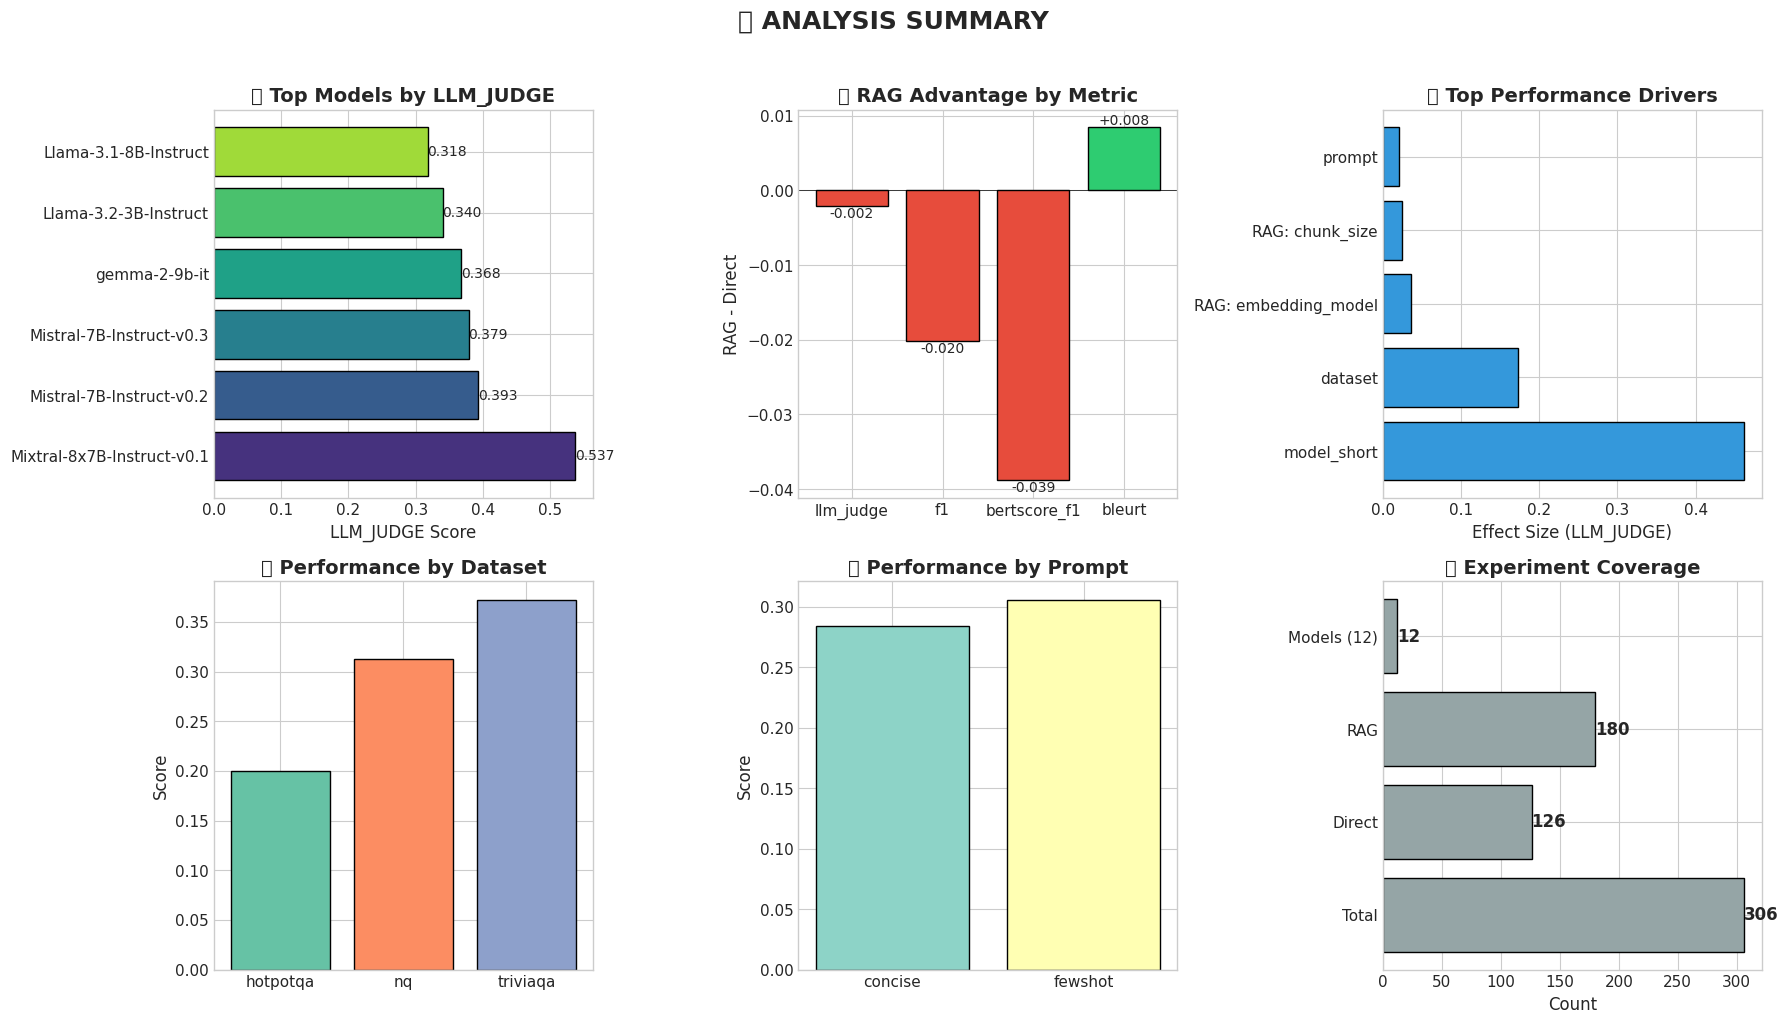


🏆 TOP 5 CONFIGURATIONS (by LLM_JUDGE):


,model_short,type,dataset,prompt,llm_judge,f1,bertscore_f1
1,Mixtral-8x7B-Instruct-v0.1,direct,triviaqa,concise,0.6600,0.5472,0.6168
0,gemma-2-9b-it,direct,triviaqa,fewshot,0.6000,0.5650,0.6320
2,gemma-2-9b-it,direct,triviaqa,fewshot,0.5700,0.5276,0.6245
49,Mixtral-8x7B-Instruct-v0.1,direct,nq,concise,0.5700,0.3337,0.5864
3,gemma-2-9b-it,direct,triviaqa,concise,0.5600,0.5037,0.6003



📊 KEY FINDINGS:
  • Total experiments analyzed: 306
  • Models tested: 12
  • Best model (LLM Judge): Mixtral-8x7B-Instruct-v0.1
  • Best prompt style: fewshot


In [75]:
# =============================================================================
# FINAL SUMMARY - Visual overview of key findings
# =============================================================================

# Create summary dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Top models by LLM Judge
ax = axes[0, 0]
if 'llm_judge' in df.columns:
    top_models = df.groupby('model_short')['llm_judge'].mean().nlargest(6)
    colors = sns.color_palette('viridis', len(top_models))
    bars = ax.barh(top_models.index, top_models.values, color=colors, edgecolor='black')
    ax.set_xlabel('LLM_JUDGE Score')
    ax.set_title('🏆 Top Models by LLM_JUDGE', fontweight='bold')
    for bar in bars:
        ax.annotate(f'{bar.get_width():.3f}', xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                   ha='left', va='center', fontsize=10)
else:
    ax.text(0.5, 0.5, 'No LLM Judge data', ha='center', va='center')

# 2. RAG vs Direct summary
ax = axes[0, 1]
if len(df_rag) > 0 and len(df_direct) > 0:
    metrics_to_compare = ['llm_judge', 'f1', 'bertscore_f1', 'bleurt']
    diffs = []
    for m in metrics_to_compare:
        if m in df.columns:
            diffs.append(df_rag[m].mean() - df_direct[m].mean())
        else:
            diffs.append(0)
    colors = ['#2ecc71' if d > 0 else '#e74c3c' for d in diffs]
    bars = ax.bar(metrics_to_compare, diffs, color=colors, edgecolor='black')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel('RAG - Direct')
    ax.set_title('🔄 RAG Advantage by Metric', fontweight='bold')
    for bar, d in zip(bars, diffs):
        ax.annotate(f'{d:+.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   ha='center', va='bottom' if d > 0 else 'top', fontsize=10)

# 3. Effect size ranking
ax = axes[0, 2]
if len(effects_df) > 0:
    bars = ax.barh(effects_df['factor'].head(5), effects_df['effect_size'].head(5), 
                   color='#3498db', edgecolor='black')
    ax.set_xlabel(f'Effect Size ({PRIMARY_METRIC.upper()})')
    ax.set_title('🎯 Top Performance Drivers', fontweight='bold')

# 4. Dataset comparison
ax = axes[1, 0]
dataset_means = df.groupby('dataset')['llm_judge' if 'llm_judge' in df.columns else 'f1'].mean()
bars = ax.bar(dataset_means.index, dataset_means.values, color=sns.color_palette('Set2', len(dataset_means)), edgecolor='black')
ax.set_ylabel('Score')
ax.set_title('📊 Performance by Dataset', fontweight='bold')

# 5. Prompt comparison
ax = axes[1, 1]
prompt_means = df.groupby('prompt')['llm_judge' if 'llm_judge' in df.columns else 'f1'].mean()
bars = ax.bar(prompt_means.index, prompt_means.values, color=sns.color_palette('Set3', len(prompt_means)), edgecolor='black')
ax.set_ylabel('Score')
ax.set_title('📝 Performance by Prompt', fontweight='bold')

# 6. Sample count summary
ax = axes[1, 2]
counts = {
    'Total': len(df),
    'Direct': len(df_direct),
    'RAG': len(df_rag),
    f'Models ({df["model_short"].nunique()})': df['model_short'].nunique(),
}
ax.barh(list(counts.keys()), list(counts.values()), color='#95a5a6', edgecolor='black')
ax.set_xlabel('Count')
ax.set_title('📋 Experiment Coverage', fontweight='bold')
for i, (k, v) in enumerate(counts.items()):
    ax.annotate(f'{v}', xy=(v, i), ha='left', va='center', fontsize=12, fontweight='bold')

plt.suptitle('📊 ANALYSIS SUMMARY', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Best configurations table
print('\n🏆 TOP 5 CONFIGURATIONS (by LLM_JUDGE):')
if 'llm_judge' in df.columns:
    best = df.nlargest(5, 'llm_judge')[['model_short', 'type', 'dataset', 'prompt', 'llm_judge', 'f1', 'bertscore_f1']]
    display(best.style.format({'llm_judge': '{:.4f}', 'f1': '{:.4f}', 'bertscore_f1': '{:.4f}'}).background_gradient(subset=['llm_judge'], cmap='RdYlGn'))

print('\n📊 KEY FINDINGS:')
print(f'  • Total experiments analyzed: {len(df)}')
print(f'  • Models tested: {df["model_short"].nunique()}')
print(f'  • Best model (LLM Judge): {df.groupby("model_short")["llm_judge"].mean().idxmax() if "llm_judge" in df.columns else "N/A"}')
print(f'  • Best prompt style: {df.groupby("prompt")["llm_judge" if "llm_judge" in df.columns else "f1"].mean().idxmax()}')

In [76]:
# Export results
output_path = repo_root / 'outputs' / 'comprehensive_analysis_export.csv'
df.to_csv(output_path, index=False)
print(f'📁 Exported results to: {output_path}')

# Export leaderboard
leaderboard_path = repo_root / 'outputs' / 'model_leaderboard.csv'
leaderboard.to_csv(leaderboard_path)
print(f'📁 Exported leaderboard to: {leaderboard_path}')

📁 Exported results to: /home/gabriel_frontera_cloudwalk_io/ragicamp/outputs/comprehensive_analysis_export.csv
📁 Exported leaderboard to: /home/gabriel_frontera_cloudwalk_io/ragicamp/outputs/model_leaderboard.csv
